<a href="https://colab.research.google.com/github/DanielFSH/Reproduce-Mechanical-Power/blob/main/Copy_of_FInalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

In [ ]:
# Import libraries
from datetime import timedelta
import os
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')

# Set up environment variables
project_id = 'kind-lab'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

# test it works
df = run_query("""
SELECT *
FROM `physionet-data.mimic_core.patients`
WHERE subject_id = 10012853
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10012853,F,91,2175,2014 - 2016,NaT


In [ ]:
df = run_query(f'''
WITH Invasive_vent AS(
SELECT stay_id, starttime, endtime, ventilation_status,
  ROW_NUMBER() OVER(PARTITION BY stay_id ORDER BY starttime) AS seq
FROM `physionet-data.mimic_derived.ventilation`
WHERE ventilation_status LIKE "%rach%" OR 
ventilation_status LIKE "InvasiveVent")
SELECT ie.subject_id, ie.hadm_id, ie.stay_id
, CASE WHEN age.anchor_age >= 16 THEN 0 ELSE 1 END AS exclude_non_adult
, CASE WHEN ROW_NUMBER() OVER (PARTITION BY ie.subject_id ORDER BY ie.intime) > 1 THEN 1 ELSE 0 END AS exclude_secondary_stay
, CASE WHEN vent.ventilation_status LIKE "InvasiveVent" THEN 0 ELSE 1 END AS exclude_tracheostomy
, CASE WHEN DATE_DIFF(vent.endtime, vent.starttime, HOUR) <= 48 THEN 1 ELSE 0 END AS exclude_short_vent
FROM `physionet-data.mimic_icu.icustays` ie
LEFT JOIN `physionet-data.mimic_derived.age` age
ON ie.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimic_core.admissions` adm
ON ie.hadm_id = adm.hadm_id
LEFT JOIN Invasive_vent vent
ON ie.stay_id = vent.stay_id AND vent.seq=1
ORDER BY ie.subject_id
''')
display(df)

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent
0,10000032,29079034,39553978,0,0,1,0
1,10000980,26913865,39765666,0,0,1,0
2,10001217,24597018,37067082,0,0,1,0
3,10001217,27703517,34592300,0,1,1,0
4,10001725,25563031,31205490,0,0,1,0
...,...,...,...,...,...,...,...
76535,19999442,26785317,32336619,0,0,0,1
76536,19999625,25304202,31070865,0,0,1,0
76537,19999828,25744818,36075953,0,0,1,0
76538,19999840,21033226,38978960,0,0,0,0


In [ ]:
df=run_query(f'''
SELECT *
FROM 
''')

In [ ]:
Table2_day2 = run_query(f'''
WITH second_dayvent AS(
  WITH Height AS(
    SELECT stay_id,
      MAX(valuenum) AS height
    FROM `physionet-data.mimic_icu.chartevents`
    WHERE itemid =226730
  GROUP BY stay_id)
  SELECT vs.subject_id,vs.stay_id,vs.charttime,tidal_volume_observed,
    CASE WHEN he.height>0 AND gender LIKE "M" THEN tidal_volume_observed/(50 + (0.91*he.height-152.4))
      WHEN he.height>0 AND gender LIKE "F" THEN tidal_volume_observed/(45.5 + (0.91*he.height-152.4)) END AS tidal_volume_pbw 
    ,peep,plateau_pressure,plateau_pressure-peep AS driving_pressure,
    CASE WHEN respiratory_rate_total IS NOT NULL AND respiratory_rate_total!=0
      THEN respiratory_rate_total ELSE respiratory_rate_spontaneous END AS resp_rate,
    minute_volume,fio2/100 as FiO2,ce.valuenum AS peak_pressure,
    CASE WHEN nb.stay_id IS NULL THEN 0 ELSE 1 END AS NBMA
  FROM `physionet-data.mimic_derived.ventilator_setting` vs
  LEFT JOIN `physionet-data.mimic_derived.ventilation` ven
    ON vs.stay_id=ven.stay_id 
  LEFT JOIN `physionet-data.mimic_icu.chartevents` ce
    ON vs.charttime=ce.charttime AND itemid=224695
  LEFT JOIN Height he
    ON vs.stay_id=he.stay_id
  LEFT JOIN `physionet-data.mimic_core.patients` pat
    ON vs.subject_id=pat.subject_id
  LEFT JOIN `physionet-data.mimic_derived.neuroblock` nb
    ON vs.stay_id=nb.stay_id
  WHERE DATE_DIFF(vs.charttime, ven.starttime, HOUR)>24 
    AND DATE_DIFF(vs.charttime, ven.starttime, HOUR)<=48)
SELECT stay_id,
CASE WHEN (MAX(0.098*(tidal_volume_observed/1000)*resp_rate*(peak_pressure-1/2*driving_pressure))+
MIN(0.098*(tidal_volume_observed/1000)*resp_rate*(peak_pressure-1/2*driving_pressure)))/2 IS NULL THEN 1 ELSE 0 END AS exclude_missingdata,
FROM second_dayvent
GROUP BY stay_id
''')
#From this join the exclude_missingdata excludes all stays without enough data to calculate MP as 1, 
df2= df.merge(Table2_day2[['stay_id','exclude_missingdata']], on='stay_id', how='left')

In [ ]:
df2.describe()

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata
count,7.654000e+04,7.654000e+04,7.654000e+04,76540.0,76540.000000,76540.000000,76540.000000,19025.000000
mean,1.499551e+07,2.498433e+07,3.499480e+07,0.0,0.305592,0.684688,0.261536,0.491511
std,2.884586e+06,2.885905e+06,2.888755e+06,0.0,0.460661,0.464643,0.439474,0.499941
min,1.000003e+07,2.000009e+07,3.000015e+07,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.248968e+07,2.248540e+07,3.249232e+07,0.0,0.000000,0.000000,0.000000,0.000000
50%,1.499694e+07,2.497627e+07,3.499660e+07,0.0,0.000000,1.000000,0.000000,0.000000
75%,1.750631e+07,2.747735e+07,3.749222e+07,0.0,1.000000,1.000000,1.000000,1.000000
max,1.999999e+07,2.999983e+07,3.999981e+07,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
final_cohort= df2[(df2['exclude_non_adult'] !=1) & (df2['exclude_secondary_stay'] !=1) & (df2['exclude_tracheostomy'] !=1) & (df2['exclude_short_vent'] !=1)& (df2['exclude_missingdata'] !=1)]

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata
47,10005606,29646384,38740124,0,0,0,0,0.0
62,10007818,22987108,32359580,0,0,0,0,0.0
127,10016742,29281842,37057036,0,0,0,0,0.0
139,10017531,22580355,35526828,0,0,0,0,0.0
175,10020944,29974575,30757476,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...
76304,19970491,25338284,30244200,0,0,0,0,0.0
76341,19975710,20266816,35393110,0,0,0,0,0.0
76450,19990427,29695607,34058245,0,0,0,0,0.0
76497,19995595,21784060,34670930,0,0,0,0,0.0


In [ ]:
final_cohort.describe()

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0


Table1_baseline = run_query(f'''
WITH icd_vals AS(SELECT subject_id, hadm_id, dia.icd_code, long_title, 
CASE WHEN long_title LIKE "%hronic obstructive pulmonary diseas%" THEN 1 ELSE 0 END AS COPD,
CASE WHEN long_title LIKE "%cute respiratory distress s%" THEN 1 ELSE 0 END AS ARDS
FROM `physionet-data.mimic_hosp.diagnoses_icd` dia
LEFT JOIN `physionet-data.mimic_hosp.d_icd_diagnoses`dic
ON dia.icd_code=dic.icd_code),
chart_vals AS(
SELECT subject_id, hadm_id, stay_id, itemid,charttime,
CASE WHEN itemid=226512 THEN valuenum END AS weight,
CASE WHEN itemid=226730 THEN valuenum END AS height
FROM `physionet-data.mimic_icu.chartevents`
WHERE itemid IN (226512,226730)),
Diagnosis AS (SELECT dia.subject_id, dia.hadm_id, dia.icd_code, dic.long_title
FROM `physionet-data.mimic_hosp.diagnoses_icd` dia
LEFT JOIN `physionet-data.mimic_hosp.d_icd_diagnoses` dic
ON dia.icd_code=dic.icd_code
WHERE seq_num=1)
SELECT pat.subject_id, MAX(anchor_age) AS Age,
  CASE WHEN MAX(gender) LIKE "M" THEN 1 ELSE 0 END AS Male,MAX(vals.weight) Weight, MAX(vals.height) Height,
  CASE WHEN MAX(vals.height)>0 THEN MAX(vals.weight)/(MAX(vals.height)*MAX(vals.height))*10000 ELSE NULL END AS BMI,
  CASE WHEN MAX(vals.height)>0 AND MAX(gender) LIKE "M" THEN 50 + (0.91*MAX(vals.height)-152.4) 
  WHEN MAX(vals.height)>0 AND MAX(gender) LIKE "F" THEN 45.5 + (0.91*MAX(vals.height)-152.4) END AS PBW,
  CASE WHEN MAX(adm.admission_type) LIKE "ELECTIVE" THEN 1 ELSE 0 END AS adm_elective,
  CASE WHEN MAX(adm.admission_type) LIKE "URGENT" THEN 1 ELSE 0 END AS adm_urgent, 
  CASE WHEN MAX(adm.admission_type) NOT LIKE "ELECTIVE" 
    AND MAX(adm.admission_type) NOT LIKE "URGENT" THEN 1 ELSE 0 END AS adm_medical, 
  MAX(adm.admission_location) AS admission_source, 
  CASE WHEN MAX(Ethnicity) LIKE "BLACK/AFRICAN AMERICAN" THEN 1 ELSE 0 END AS eth_black, 
  CASE WHEN MAX(Ethnicity) LIKE "HISPANIC/LATINO%" THEN 1 ELSE 0 END AS eth_hispanic,
  CASE WHEN MAX(Ethnicity) LIKE "WHITE%" THEN 1 ELSE 0 END AS eth_white,
  CASE WHEN MAX(Ethnicity) NOT LIKE "B%" 
    AND MAX(Ethnicity) NOT LIKE "H%" 
    AND MAX(Ethnicity) NOT LIKE "W%" THEN 1 ELSE 0 END AS eth_other,
  MAX(diag.long_title) AS Initial_diagnosis,
  CASE WHEN MAX(diag.long_title) LIKE "%epsis%" 
    OR MAX(diag.long_title) LIKE "%neumonia%" 
    AND MAX(diag.long_title) NOT LIKE "%neumoniae%" THEN 1 ELSE 0 END as Sepsis,
  CASE WHEN (MAX(diag.long_title) LIKE "%ardiov%"
    OR MAX(diag.long_title) LIKE "%eart f%"
    OR MAX(diag.long_title) LIKE "%eart d%"
    OR MAX(diag.long_title) LIKE "%troke%")
    AND MAX(diag.long_title) NOT LIKE "%eat%"
    AND MAX(diag.long_title) NOT LIKE "%amily history%" 
    AND MAX(diag.long_title) NOT LIKE "%, without heart%" THEN 1 ELSE 0 END AS Card_disease,
   MAX(ic.COPD) AS COPD, 
  #comorbidity score
  MAX(ic.ARDS) AS ARDS
FROM  `physionet-data.mimic_core.patients`pat
INNER JOIN chart_vals vals
ON pat.subject_id=vals.subject_id
LEFT JOIN `physionet-data.mimic_core.admissions` adm
ON pat.subject_id=adm.subject_id
LEFT JOIN Diagnosis diag
ON adm.hadm_id=diag.hadm_id
LEFT JOIN icd_vals ic
ON pat.subject_id=ic.subject_id
#Will add a join to cohort, which only allows for the first admission
GROUP BY subject_id
ORDER BY subject_id
''')
display(Table1)

In [ ]:
Table1_baseline = run_query(f'''
WITH icd_vals AS(SELECT subject_id, hadm_id, dia.icd_code, long_title, 
CASE WHEN long_title LIKE "%hronic obstructive pulmonary diseas%" THEN 1 ELSE 0 END AS COPD,
CASE WHEN long_title LIKE "%cute respiratory distress s%" THEN 1 ELSE 0 END AS ARDS
FROM `physionet-data.mimic_hosp.diagnoses_icd` dia
LEFT JOIN `physionet-data.mimic_hosp.d_icd_diagnoses`dic
ON dia.icd_code=dic.icd_code),
chart_vals AS(
SELECT subject_id, hadm_id, stay_id, itemid,charttime,
CASE WHEN itemid=226512 THEN valuenum END AS weight,
CASE WHEN itemid=226730 THEN valuenum END AS height
FROM `physionet-data.mimic_icu.chartevents`
WHERE itemid IN (226512,226730)),
Diagnosis AS (SELECT dia.subject_id, dia.hadm_id, dia.icd_code, dic.long_title
FROM `physionet-data.mimic_hosp.diagnoses_icd` dia
LEFT JOIN `physionet-data.mimic_hosp.d_icd_diagnoses` dic
ON dia.icd_code=dic.icd_code
WHERE seq_num=1)
SELECT pat.subject_id, MAX(anchor_age) AS Age,
  CASE WHEN MAX(gender) LIKE "M" THEN 1 ELSE 0 END AS Male,MAX(vals.weight) Weight, MAX(vals.height) Height,
  CASE WHEN MAX(vals.height)>0 THEN MAX(vals.weight)/(MAX(vals.height)*MAX(vals.height))*10000 ELSE NULL END AS BMI,
  CASE WHEN MAX(vals.height)>0 AND MAX(gender) LIKE "M" THEN 50 + (0.91*MAX(vals.height)-152.4) 
  WHEN MAX(vals.height)>0 AND MAX(gender) LIKE "F" THEN 45.5 + (0.91*MAX(vals.height)-152.4) END AS PBW,
  CASE WHEN MAX(adm.admission_type) LIKE "ELECTIVE" THEN 1 ELSE 0 END AS adm_elective,
  CASE WHEN MAX(adm.admission_type) LIKE "URGENT" THEN 1 ELSE 0 END AS adm_urgent, 
  CASE WHEN MAX(adm.admission_type) NOT LIKE "ELECTIVE" 
    AND MAX(adm.admission_type) NOT LIKE "URGENT" THEN 1 ELSE 0 END AS adm_medical, 
  MAX(adm.admission_location) AS admission_source, 
  CASE WHEN MAX(adm.admission_location) LIKE "INTERNAL TRANSFER TO OR FROM PSYCH" THEN 1 ELSE 0 END AS adms_internal,
  CASE WHEN MAX(adm.admission_location) LIKE "EMERGENCY ROOM" THEN 1 ELSE 0 END AS adms_emergency, 
  CASE WHEN MAX(adm.admission_location) LIKE "AMBULATORY SURGERY TRANSFER" THEN 1 ELSE 0 END AS adms_surgery, 
  CASE WHEN MAX(adm.admission_location) LIKE "TRANSFER FROM HOSPITAL" THEN 1 ELSE 0 END AS adms_transfer, 
  CASE WHEN MAX(adm.admission_location) NOT LIKE "INTERNAL TRANSFER TO OR FROM PSYCH"
    AND MAX(adm.admission_location) NOT LIKE "EMERGENCY ROOM"
    AND MAX(adm.admission_location) NOT LIKE "AMBULATORY SURGERY TRANSFER"
    AND MAX(adm.admission_location) NOT LIKE "TRANSFER FROM HOSPITAL" THEN 1 ELSE 0 END AS adms_other,
  CASE WHEN MAX(Ethnicity) LIKE "BLACK/AFRICAN AMERICAN" THEN 1 ELSE 0 END AS eth_black, 
  CASE WHEN MAX(Ethnicity) LIKE "HISPANIC/LATINO%" THEN 1 ELSE 0 END AS eth_hispanic,
  CASE WHEN MAX(Ethnicity) LIKE "WHITE%" THEN 1 ELSE 0 END AS eth_white,
  CASE WHEN MAX(Ethnicity) NOT LIKE "B%" 
    AND MAX(Ethnicity) NOT LIKE "H%" 
    AND MAX(Ethnicity) NOT LIKE "W%" THEN 1 ELSE 0 END AS eth_other,
   MAX(ic.COPD) AS COPD, 
  #comorbidity score
  MAX(ic.ARDS) AS ARDS
FROM  `physionet-data.mimic_core.patients`pat
INNER JOIN chart_vals vals
ON pat.subject_id=vals.subject_id
LEFT JOIN `physionet-data.mimic_core.admissions` adm
ON pat.subject_id=adm.subject_id
LEFT JOIN icd_vals ic
ON pat.subject_id=ic.subject_id
GROUP BY subject_id
ORDER BY subject_id
''')
display(Table1_baseline)

,subject_id,Age,Male,Weight,Height,BMI,PBW,adm_elective,adm_urgent,adm_medical,...,adms_emergency,adms_surgery,adms_transfer,adms_other,eth_black,eth_hispanic,eth_white,eth_other,COPD,ARDS
0,10000032,52,0,39.4,152.0,17.053324,31.42,0,1,0,...,0,0,1,0,0,0,1,0,0.0,0.0
1,10000980,73,0,76.2,NaN,NaN,NaN,0,0,1,...,0,0,0,1,1,0,0,0,0.0,0.0
2,10001217,55,0,74.8,NaN,NaN,NaN,0,0,1,...,0,0,0,1,0,0,1,0,0.0,0.0
3,10001725,46,0,72.2,157.0,29.291249,35.97,0,0,1,...,0,0,0,1,0,0,1,0,0.0,0.0
4,10001884,68,0,65.0,157.0,26.370238,35.97,0,0,1,...,0,0,0,1,1,0,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53098,19999442,41,1,107.5,193.0,28.859835,73.23,1,0,0,...,0,0,0,1,0,0,1,0,0.0,0.0
53099,19999625,81,1,50.5,NaN,NaN,NaN,0,0,1,...,1,0,0,0,0,0,1,0,0.0,0.0
53100,19999828,46,0,67.9,NaN,NaN,NaN,0,0,1,...,0,0,1,0,0,0,1,0,1.0,0.0
53101,19999840,58,1,77.5,178.0,24.460295,59.58,0,0,1,...,1,0,0,0,0,0,1,0,0.0,0.0


In [ ]:
 Table1_baselinefinal = final_cohort.merge(Table1_baseline, on='subject_id', how='left')

In [ ]:
Table1_baselinefinal[['Age', 'Weight', 'Height', 'BMI', 'PBW',]].describe()

,Age,Weight,Height,BMI,PBW
count,3117.000000,3117.000000,2757.000000,2756.000000,2756.000000
mean,59.599936,87.099647,169.698498,92.714994,50.221906
std,17.319638,27.385446,12.390111,3183.750820,12.361366
min,18.000000,1.000000,0.000000,12.541432,-99.670000
25%,48.000000,69.500000,163.000000,24.425366,41.430000
50%,61.000000,83.000000,170.000000,28.604765,52.300000
75%,73.000000,100.000000,178.000000,34.312082,59.580000
max,91.000000,345.000000,203.000000,167111.111111,77.830000


In [ ]:
Table1_baselinefinal['Male'].value_counts()

1    1819
0    1298
Name: Male, dtype: int64

In [ ]:
Table1_baselinefinal[['adm_elective', 'adm_urgent', 'adm_medical']].value_counts()

adm_elective  adm_urgent  adm_medical
0             0           1              1962
              1           0              1129
1             0           0                26
dtype: int64

In [ ]:
Table1_baselinefinal[['eth_black', 'eth_hispanic', 'eth_white', 'eth_other']].value_counts()

eth_black  eth_hispanic  eth_white  eth_other
0          0             1          0            1837
                         0          1             905
1          0             0          0             270
0          1             0          0             105
dtype: int64

In [ ]:
Table1_baselinefinal[['adms_internal','adms_emergency','adms_surgery','adms_transfer','adms_other']].value_counts()

adms_internal  adms_emergency  adms_surgery  adms_transfer  adms_other
0              0               0             1              0             1136
               1               0             0              0             1060
               0               0             0              1              910
1              0               0             0              0                8
0              0               1             0              0                3
dtype: int64

In [ ]:
Table1_baselinefinal['COPD'].value_counts()

0.0    2832
1.0     285
Name: COPD, dtype: int64

In [ ]:
Table1_ARDS = run_query(f'''
WITH ARD AS (SELECT MAX(adm.subject_id) AS subject_id, adm.hadm_id, MAX(vent.peep)AS PEEP, MAX(bg.pao2fio2ratio) AS PAO2FIO2
FROM `physionet-data.mimic_core.admissions` adm
LEFT JOIN `physionet-data.mimic_derived.ventilator_setting` vent
ON adm.subject_id=vent.subject_id
LEFT JOIN `physionet-data.mimic_derived.bg` bg
ON adm.hadm_id=bg.hadm_id
WHERE DATE_DIFF(vent.charttime, adm.admittime, HOUR)<48
GROUP BY adm.hadm_id)
SELECT subject_id, hadm_id,
CASE WHEN 200<PAO2FIO2 AND PAO2FIO2<=300 AND PEEP>=5 THEN 1 ELSE 0 END AS ARD_Mild,
CASE WHEN 100<PAO2FIO2 AND PAO2FIO2<=200 AND PEEP>=5 THEN 1 ELSE 0 END AS ARD_Moderate,
CASE WHEN PAO2FIO2<=100 AND PEEP>=5 THEN 1 ELSE 0 END AS ARD_Severe
FROM ARD
ORDER BY ARD.subject_id
''')
Table1_ARDSfinal = final_cohort.merge(Table1_ARDS, on='hadm_id', how='left')
display(Table1_ARDSfinal)

,subject_id_x,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,ARD_Mild,ARD_Moderate,ARD_Severe
0,10005606,29646384,38740124,0,0,0,0,0.0,10005606.0,0.0,0.0,0.0
1,10007818,22987108,32359580,0,0,0,0,0.0,NaN,NaN,NaN,NaN
2,10016742,29281842,37057036,0,0,0,0,0.0,10016742.0,0.0,0.0,0.0
3,10017531,22580355,35526828,0,0,0,0,0.0,10017531.0,1.0,0.0,0.0
4,10020944,29974575,30757476,0,0,0,0,0.0,10020944.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3112,19970491,25338284,30244200,0,0,0,0,0.0,19970491.0,0.0,0.0,0.0
3113,19975710,20266816,35393110,0,0,0,0,0.0,19975710.0,0.0,1.0,0.0
3114,19990427,29695607,34058245,0,0,0,0,0.0,NaN,NaN,NaN,NaN
3115,19995595,21784060,34670930,0,0,0,0,0.0,19995595.0,0.0,0.0,0.0


In [ ]:
Table1_ARDSfinal[['ARD_Mild', 'ARD_Moderate', 'ARD_Severe']].value_counts()

ARD_Mild  ARD_Moderate  ARD_Severe
0.0       0.0           0.0           2035
1.0       0.0           0.0            504
0.0       1.0           0.0            159
          0.0           1.0             15
dtype: int64

In [ ]:
Table1_VRRT = run_query(f'''
SELECT ic.stay_id, 
CASE WHEN MAX(vas.stay_id) IS NULL THEN 0 ELSE 1 END AS Vassopressors,
CASE WHEN MAX(rrt.dialysis_present) IS NULL THEN 0 ELSE 1 END AS RRT
FROM `physionet-data.mimic_icu.icustays` ic
LEFT JOIN `physionet-data.mimic_derived.vasopressin` vas
ON ic.stay_id=vas.stay_id AND DATE_DIFF(vas.starttime,ic.intime, HOUR)<24
LEFT JOIN `physionet-data.mimic_derived.first_day_rrt` rrt
ON ic.stay_id=rrt.stay_id
GROUP BY ic.stay_id
ORDER BY ic.stay_id
''')
Table1_VRRTfinal = final_cohort.merge(Table1_VRRT, on='stay_id', how='left')
Table1_VRRTfinal['Vassopressors'].value_counts()

0    2530
1     587
Name: Vassopressors, dtype: int64

In [ ]:
Table1_VRRTfinal['RRT'].value_counts()

0    2825
1     292
Name: RRT, dtype: int64

In [ ]:
Table1_severity = run_query(f'''
SELECT ic.stay_id, saps.sapsii, oasis.oasis, sofa.SOFA
FROM `physionet-data.mimic_icu.icustays` ic
LEFT JOIN `physionet-data.mimic_derived.sapsii` saps
ON ic.stay_id=saps.stay_id
LEFT JOIN `physionet-data.mimic_derived.oasis` oasis
ON ic.stay_id=oasis.stay_id
LEFT JOIN `physionet-data.mimic_derived.first_day_sofa` sofa
ON ic.stay_id=sofa.stay_id
ORDER BY stay_id
''')
Table1_severityfinal = final_cohort.merge(Table1_severity, on='stay_id', how='left')
Table1_severityfinal[['sapsii', 'oasis','SOFA']].describe()

,sapsii,oasis,SOFA
count,3117.000000,3117.000000,3117.000000
mean,45.806545,42.662817,9.801412
std,16.168901,8.541799,4.286217
min,6.000000,17.000000,0.000000
25%,34.000000,37.000000,6.000000
50%,44.000000,42.000000,10.000000
75%,56.000000,49.000000,13.000000
max,107.000000,71.000000,23.000000


In [ ]:
Table1_chartevent = run_query(f'''
#First I'm going to find a list of itemids for all the first 24 hours variables:
#Heart rate: 220045,Mean arterial pressure:220052,Patient  O2 saturation:220277,Temperature:223762,pH:223830,PaO2:220224
#Fi02:223835,PaCo2:220235,SAS:223753
WITH covariates AS (
SELECT subject_id, hadm_id, stay_id, itemid,charttime,
CASE WHEN itemid=220045 THEN valuenum END AS Heartrate,
CASE WHEN itemid=220052 THEN valuenum END AS MAP,
CASE WHEN itemid=220277 THEN valuenum END AS SpO2,
CASE WHEN itemid=223762 THEN valuenum END AS Temperature,
CASE WHEN itemid=223753 THEN valuenum END AS SAS
FROM `physionet-data.mimic_icu.chartevents`
WHERE itemid IN (220045,220052, 220277,223762,223753))
SELECT cov.subject_id,cov.hadm_id,
(MAX(cov.Heartrate)+MIN(cov.Heartrate))/2 AS avg_Heartrate,
(MAX(cov.MAP)+MIN(cov.MAP))/2 AS avg_MAP,
(MAX(cov.SpO2)+MIN(cov.SpO2))/2 AS avg_SpO2,
(MAX(cov.Temperature)+MIN(cov.Temperature))/2 AS avg_Temp
FROM covariates cov
LEFT JOIN `physionet-data.mimic_icu.icustays` ie
ON cov.hadm_id=ie.hadm_id
LEFT JOIN `physionet-data.mimic_derived.ventilation` vent
ON ie.stay_id=vent.stay_id
WHERE DATE_DIFF(cov.charttime, vent.starttime, HOUR)<=24
GROUP BY cov.subject_id, cov.hadm_id
''')
Table1_cefinal = final_cohort.merge(Table1_chartevent, on='hadm_id', how='left')
Table1_cefinal.describe()

,subject_id_x,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,avg_Heartrate,avg_MAP,avg_SpO2,avg_Temp
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3.117000e+03,3117.000000,2517.000000,3.117000e+03,958.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.494541e+07,140.361566,389.651768,1.656410e+03,38.274843
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.848087e+06,1503.142015,9519.214856,8.695954e+04,8.915895
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,41.500000,-11.500000,-2.890000e+02,0.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.251970e+07,83.500000,76.000000,9.050000e+01,35.850000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.499892e+07,94.000000,88.500000,9.400000e+01,36.900000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.732759e+07,104.000000,122.000000,9.550000e+01,37.700000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,51080.500000,465015.500000,4.855050e+06,206.750000


In [ ]:
Table1_labevent = run_query(f'''
#You should extract lab values such as PaO2, pH, and PaCO2 from the labevents table and/or one of the derived tables. PaO2/#FiO2 requires both labs and chartevents
SELECT bg.subject_id,bg.hadm_id,
(MAX(bg.pao2fio2ratio)+MIN(bg.pao2fio2ratio))/2 AS avg_pao2fio2ratio,
(MAX(bg.ph)+MIN(bg.ph))/2 AS avg_ph,
(MAX(bg.pco2)+MIN(bg.pco2))/2 AS avg_paco2,
FROM `physionet-data.mimic_derived.bg` bg
LEFT JOIN `physionet-data.mimic_icu.icustays` ie
ON bg.hadm_id=ie.hadm_id
LEFT JOIN `physionet-data.mimic_derived.ventilation` vent
ON ie.stay_id=vent.stay_id
WHERE DATE_DIFF(bg.charttime, vent.starttime, HOUR)<24
  AND bg.specimen LIKE "ART."
GROUP BY bg.subject_id, bg.hadm_id
''')
Table1_lefinal = final_cohort.merge(Table1_labevent, on='hadm_id', how='left')
Table1_lefinal.describe()

,subject_id_x,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,avg_pao2fio2ratio,avg_ph,avg_paco2
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,2.975000e+03,2951.000000,2975.000000,2975.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.496284e+07,280.343231,7.358748,43.768571
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.856887e+06,123.305978,0.072628,10.270688
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,25.000000,7.035000,17.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.251754e+07,197.500000,7.315000,37.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.500950e+07,255.000000,7.365000,42.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.734999e+07,336.000000,7.410000,48.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,1045.000000,7.585000,125.500000


In [ ]:
Table1_Elix = run_query(f'''
WITH Elixhauser_comorbidity AS (
with eliflg as
(
select hadm_id, seq_num, icd_code
-- note that these codes will seem incomplete at first
-- for example, CHF is missing a lot of codes referenced in the literature (402.11, 402.91, etc)
-- these codes are captured by hypertension flags instead
-- later there are some complicated rules which confirm/reject those codes as chf
, CASE
  when icd_code = '39891' then 1
  when icd_code between '4280' and '4289' then 1
		end as chf       /* Congestive heart failure */

-- cardiac arrhythmias is removed in up to date versions
, case
    when icd_code = '42610' then 1
    when icd_code = '42611' then 1
    when icd_code = '42613' then 1
    when icd_code between '4262' and '42653' then 1
    when icd_code between '4266' and '42689' then 1
    when icd_code = '4270' then 1
    when icd_code = '4272' then 1
    when icd_code = '42731' then 1
    when icd_code = '42760' then 1
    when icd_code = '4279' then 1
    when icd_code = '7850' then 1
    when icd_code between 'V450' and 'V4509' then 1
    when icd_code between 'V533' and 'V5339' then 1
  end as arythm /* Cardiac arrhythmias */

, CASE
  when icd_code between '09320' and '09324' then 1
  when icd_code between '3940' and '3971' then 1
  when icd_code = '3979' then 1
  when icd_code between '4240' and '42499' then 1
  when icd_code between '7463' and '7466' then 1
  when icd_code = 'V422' then 1
  when icd_code = 'V433' then 1
		end as valve     /* Valvular disease */

, CASE
  when icd_code between '41511' and '41519' then 1
  when icd_code between '4160' and '4169' then 1
  when icd_code = '4179' then 1
		end as pulmcirc  /* Pulmonary circulation disorder */

, CASE
  when icd_code between '4400' and '4409' then 1
  when icd_code between '44100' and '4419' then 1
  when icd_code between '4420' and '4429' then 1
  when icd_code between '4431' and '4439' then 1
  when icd_code between '44421' and '44422' then 1
  when icd_code = '4471' then 1
  when icd_code = '449' then 1
  when icd_code = '5571' then 1
  when icd_code = '5579' then 1
  when icd_code = 'V434' then 1
		end as perivasc  /* Peripheral vascular disorder */

, CASE
  when icd_code = '4011' then 1
  when icd_code = '4019' then 1
  when icd_code between '64200' and '64204' then 1
		end as htn       /* Hypertension, uncomplicated */

, CASE
  when icd_code = '4010' then 1
  when icd_code = '4372' then 1
		end as htncx     /* Hypertension, complicated */


      /******************************************************************/
      /* The following are special, temporary formats used in the       */
      /* creation of the hypertension complicated comorbidity when      */
      /* overlapping with congestive heart failure or renal failure     */
      /* occurs. These temporary formats are referenced in the program  */
      /* called comoanaly2009.txt.                                      */
      /******************************************************************/
, CASE
  when icd_code between '64220' and '64224' then 1
		end as htnpreg   /* Pre-existing hypertension complicating pregnancy */

, CASE
  when icd_code = '40200' then 1
  when icd_code = '40210' then 1
  when icd_code = '40290' then 1
  when icd_code = '40509' then 1
  when icd_code = '40519' then 1
  when icd_code = '40599'         then 1
		end as htnwochf  /* Hypertensive heart disease without heart failure */

, CASE
  when icd_code = '40201' then 1
  when icd_code = '40211' then 1
  when icd_code = '40291'         then 1
		end as htnwchf   /* Hypertensive heart disease with heart failure */

, CASE
  when icd_code = '40300' then 1
  when icd_code = '40310' then 1
  when icd_code = '40390' then 1
  when icd_code = '40501' then 1
  when icd_code = '40511' then 1
  when icd_code = '40591' then 1
  when icd_code between '64210' and '64214' then 1
		end as hrenworf  /* Hypertensive renal disease without renal failure */

, CASE
  when icd_code = '40301' then 1
  when icd_code = '40311' then 1
  when icd_code = '40391'         then 1
		end as hrenwrf   /* Hypertensive renal disease with renal failure */

, CASE
  when icd_code = '40400' then 1
  when icd_code = '40410' then 1
  when icd_code = '40490'         then 1
		end as hhrwohrf  /* Hypertensive heart and renal disease without heart or renal failure */

, CASE
  when icd_code = '40401' then 1
  when icd_code = '40411' then 1
  when icd_code = '40491'         then 1
		end as hhrwchf   /* Hypertensive heart and renal disease with heart failure */

, CASE
  when icd_code = '40402' then 1
  when icd_code = '40412' then 1
  when icd_code = '40492'         then 1
		end as hhrwrf    /* Hypertensive heart and renal disease with renal failure */

, CASE
  when icd_code = '40403' then 1
  when icd_code = '40413' then 1
  when icd_code = '40493'         then 1
		end as hhrwhrf   /* Hypertensive heart and renal disease with heart and renal failure */

, CASE
  when icd_code between '64270' and '64274' then 1
  when icd_code between '64290' and '64294' then 1
		end as ohtnpreg  /* Other hypertension in pregnancy */

      /******************** End Temporary Formats ***********************/

, CASE
  when icd_code between '3420' and '3449' then 1
  when icd_code between '43820' and '43853' then 1
  when icd_code = '78072'         then 1
		end as para      /* Paralysis */

, CASE
  when icd_code between '3300' and '3319' then 1
  when icd_code = '3320' then 1
  when icd_code = '3334' then 1
  when icd_code = '3335' then 1
  when icd_code = '3337' then 1
  when icd_code in ('33371','33372','33379','33385','33394') then 1
  when icd_code between '3340' and '3359' then 1
  when icd_code = '3380' then 1
  when icd_code = '340' then 1
  when icd_code between '3411' and '3419' then 1
  when icd_code between '34500' and '34511' then 1
  when icd_code between '3452' and '3453' then 1
  when icd_code between '34540' and '34591' then 1
  when icd_code between '34700' and '34701' then 1
  when icd_code between '34710' and '34711' then 1
  when icd_code = '3483' then 1 -- discontinued icd-9
  when icd_code between '64940' and '64944' then 1
  when icd_code = '7687' then 1
  when icd_code between '76870' and '76873' then 1
  when icd_code = '7803' then 1
  when icd_code = '78031' then 1
  when icd_code = '78032' then 1
  when icd_code = '78033' then 1
  when icd_code = '78039' then 1
  when icd_code = '78097' then 1
  when icd_code = '7843'         then 1
		end as neuro     /* Other neurological */

, CASE
  when icd_code between '490' and '4928' then 1
  when icd_code between '49300' and '49392' then 1
  when icd_code between '494' and '4941' then 1
  when icd_code between '4950' and '505' then 1
  when icd_code = '5064'         then 1
		end as chrnlung  /* Chronic pulmonary disease */

, CASE
  when icd_code between '25000' and '25033' then 1
  when icd_code between '64800' and '64804' then 1
  when icd_code between '24900' and '24931' then 1
		end as dm        /* Diabetes w/o chronic complications*/

, CASE
  when icd_code between '25040' and '25093' then 1
  when icd_code = '7751' then 1
  when icd_code between '24940' and '24991' then 1
		end as dmcx      /* Diabetes w/ chronic complications */

, CASE
  when icd_code between '243' and '2442' then 1
  when icd_code = '2448' then 1
  when icd_code = '2449'         then 1
		end as hypothy   /* Hypothyroidism */

, CASE
  when icd_code = '585' then 1 -- discontinued code
  when icd_code = '5853' then 1
  when icd_code = '5854' then 1
  when icd_code = '5855' then 1
  when icd_code = '5856' then 1
  when icd_code = '5859' then 1
  when icd_code = '586' then 1
  when icd_code = 'V420' then 1
  when icd_code = 'V451' then 1
  when icd_code between 'V560' and 'V5632' then 1
  when icd_code = 'V568' then 1
  when icd_code between 'V4511' and 'V4512' then 1
		end as renlfail  /* Renal failure */

, CASE
  when icd_code = '07022' then 1
  when icd_code = '07023' then 1
  when icd_code = '07032' then 1
  when icd_code = '07033' then 1
  when icd_code = '07044' then 1
  when icd_code = '07054' then 1
  when icd_code = '4560' then 1
  when icd_code = '4561' then 1
  when icd_code = '45620' then 1
  when icd_code = '45621' then 1
  when icd_code = '5710' then 1
  when icd_code = '5712' then 1
  when icd_code = '5713' then 1
  when icd_code between '57140' and '57149' then 1
  when icd_code = '5715' then 1
  when icd_code = '5716' then 1
  when icd_code = '5718' then 1
  when icd_code = '5719' then 1
  when icd_code = '5723' then 1
  when icd_code = '5728' then 1
  when icd_code = '5735' then 1
  when icd_code = 'V427'         then 1
		end as liver     /* Liver disease */

, CASE
  when icd_code = '53141' then 1
  when icd_code = '53151' then 1
  when icd_code = '53161' then 1
  when icd_code = '53170' then 1
  when icd_code = '53171' then 1
  when icd_code = '53191' then 1
  when icd_code = '53241' then 1
  when icd_code = '53251' then 1
  when icd_code = '53261' then 1
  when icd_code = '53270' then 1
  when icd_code = '53271' then 1
  when icd_code = '53291' then 1
  when icd_code = '53341' then 1
  when icd_code = '53351' then 1
  when icd_code = '53361' then 1
  when icd_code = '53370' then 1
  when icd_code = '53371' then 1
  when icd_code = '53391' then 1
  when icd_code = '53441' then 1
  when icd_code = '53451' then 1
  when icd_code = '53461' then 1
  when icd_code = '53470' then 1
  when icd_code = '53471' then 1
  when icd_code = '53491'         then 1
		end as ulcer     /* Chronic Peptic ulcer disease (includes bleeding only if obstruction is also present) */

, CASE
  when icd_code between '042' and '0449' then 1
		end as aids      /* HIV and AIDS */

, CASE
  when icd_code between '20000' and '20238' then 1
  when icd_code between '20250' and '20301' then 1
  when icd_code = '2386' then 1
  when icd_code = '2733' then 1
  when icd_code between '20302' and '20382' then 1
		end as lymph     /* Lymphoma */

, CASE
  when icd_code between '1960' and '1991' then 1
  when icd_code between '20970' and '20975' then 1
  when icd_code = '20979' then 1
  when icd_code = '78951'         then 1
		end as mets      /* Metastatic cancer */

, CASE
  when icd_code between '1400' and '1729' then 1
  when icd_code between '1740' and '1759' then 1
  when icd_code between '179' and '1958' then 1
  when icd_code between '20900' and '20924' then 1
  when icd_code between '20925' and '2093' then 1
  when icd_code between '20930' and '20936' then 1
  when icd_code between '25801' and '25803' then 1
		end as tumor     /* Solid tumor without metastasis */

, CASE
  when icd_code = '7010' then 1
  when icd_code between '7100' and '7109' then 1
  when icd_code between '7140' and '7149' then 1
  when icd_code between '7200' and '7209' then 1
  when icd_code = '725' then 1
		end as arth              /* Rheumatoid arthritis/collagen vascular diseases */

, CASE
  when icd_code between '2860' and '2869' then 1
  when icd_code = '2871' then 1
  when icd_code between '2873' and '2875' then 1
  when icd_code between '64930' and '64934' then 1
  when icd_code = '28984'         then 1
		end as coag      /* Coagulation deficiency */

, CASE
  when icd_code = '2780' then 1
  when icd_code = '27800' then 1
  when icd_code = '27801' then 1
  when icd_code = '27803' then 1
  when icd_code between '64910' and '64914' then 1
  when icd_code between 'V8530' and 'V8539' then 1
  when icd_code = 'V854' then 1 -- hierarchy used for AHRQ v3.6 and earlier
  when icd_code between 'V8541' and 'V8545' then 1
  when icd_code = 'V8554' then 1
  when icd_code = '79391'         then 1
		end as obese     /* Obesity      */

, CASE
  when icd_code between '260' and '2639' then 1
  when icd_code between '78321' and '78322' then 1
		end as wghtloss  /* Weight loss */

, CASE
  when icd_code between '2760' and '2769' then 1
		end as lytes     /* Fluid and electrolyte disorders - note:
                                      this comorbidity should be dropped when
                                      used with the AHRQ Patient Safety Indicators*/
, CASE
  when icd_code = '2800' then 1
  when icd_code between '64820' and '64824' then 1
		end as bldloss   /* Blood loss anemia */

, CASE
  when icd_code between '2801' and '2819' then 1
  when icd_code between '28521' and '28529' then 1
  when icd_code = '2859'         then 1
		end as anemdef  /* Deficiency anemias */

, CASE
  when icd_code between '2910' and '2913' then 1
  when icd_code = '2915' then 1
  when icd_code = '2918' then 1
  when icd_code = '29181' then 1
  when icd_code = '29182' then 1
  when icd_code = '29189' then 1
  when icd_code = '2919' then 1
  when icd_code between '30300' and '30393' then 1
  when icd_code between '30500' and '30503' then 1
		end as alcohol   /* Alcohol abuse */

, CASE
  when icd_code = '2920' then 1
  when icd_code between '29282' and '29289' then 1
  when icd_code = '2929' then 1
  when icd_code between '30400' and '30493' then 1
  when icd_code between '30520' and '30593' then 1
  when icd_code between '64830' and '64834' then 1
		end as drug      /* Drug abuse */

, CASE
  when icd_code between '29500' and '2989' then 1
  when icd_code = '29910' then 1
  when icd_code = '29911'         then 1
		end as psych    /* Psychoses */

, CASE
  when icd_code = '3004' then 1
  when icd_code = '30112' then 1
  when icd_code = '3090' then 1
  when icd_code = '3091' then 1
  when icd_code = '311'         then 1
		end as depress  /* Depression */
from `physionet-data.mimic_hosp.diagnoses_icd` icd
WHERE seq_num = 1 AND icd_version=9
)
-- collapse the icd_code specific flags into hadm_id specific flags
-- this groups comorbidities together for a single patient admission
, eligrp as
(
  select hadm_id
  , max(chf) as chf
  , max(arythm) as arythm
  , max(valve) as valve
  , max(pulmcirc) as pulmcirc
  , max(perivasc) as perivasc
  , max(htn) as htn
  , max(htncx) as htncx
  , max(htnpreg) as htnpreg
  , max(htnwochf) as htnwochf
  , max(htnwchf) as htnwchf
  , max(hrenworf) as hrenworf
  , max(hrenwrf) as hrenwrf
  , max(hhrwohrf) as hhrwohrf
  , max(hhrwchf) as hhrwchf
  , max(hhrwrf) as hhrwrf
  , max(hhrwhrf) as hhrwhrf
  , max(ohtnpreg) as ohtnpreg
  , max(para) as para
  , max(neuro) as neuro
  , max(chrnlung) as chrnlung
  , max(dm) as dm
  , max(dmcx) as dmcx
  , max(hypothy) as hypothy
  , max(renlfail) as renlfail
  , max(liver) as liver
  , max(ulcer) as ulcer
  , max(aids) as aids
  , max(lymph) as lymph
  , max(mets) as mets
  , max(tumor) as tumor
  , max(arth) as arth
  , max(coag) as coag
  , max(obese) as obese
  , max(wghtloss) as wghtloss
  , max(lytes) as lytes
  , max(bldloss) as bldloss
  , max(anemdef) as anemdef
  , max(alcohol) as alcohol
  , max(drug) as drug
  , max(psych) as psych
  , max(depress) as depress
from eliflg
group by hadm_id
)

-- DRG FILTER --
, msdrg as
(
select
  hadm_id
/**** V29 MS-DRG Formats ****/

/* Cardiac */
, case
    when d.drg_code between 001 and 002 then 1
    when d.drg_code between 215 and 238 then 1
    when d.drg_code between 242 and 252 then 1
    when d.drg_code between 253 and 254 then 1
    when d.drg_code between 258 and 262 then 1
    when d.drg_code between 265 and 267 then 1
    when d.drg_code between 280 and 293 then 1
    when d.drg_code between 296 and 298 then 1
    when d.drg_code between 302 and 303 then 1
    when d.drg_code between 306 and 313 then 1
else 0 end as carddrg

/* Peripheral vascular */
, case
    when d.drg_code between 299 and 301 then 1
else 0 end as peridrg

/* Renal */
, case
    when d.drg_code = 652 then 1
    when d.drg_code between 656 and 661 then 1
    when d.drg_code between 673 and 675 then 1
    when d.drg_code between 682 and 700 then 1
else 0 end as renaldrg

/* Nervous system */
, case
    when d.drg_code between 020 and 042 then 1
    when d.drg_code between 052 and 103 then 1
else 0 end as nervdrg

/* Cerebrovascular */
, case
    when d.drg_code between 020 and 022 then 1
    when d.drg_code between 034 and 039 then 1
    when d.drg_code between 064 and 072 then 1
else 0 end as ceredrg

/* COPD asthma */
, case
    when d.drg_code between 190 and 192 then 1
    when d.drg_code between 202 and 203 then 1
else 0 end as pulmdrg

/* Diabetes */
, case
    when d.drg_code between 637 and 639 then 1
else 0 end as  DIABDRG

/* Thyroid endocrine */
, case
    when d.drg_code between 625 and 627 then 1
    when d.drg_code between 643 and 645 then 1
else 0 end as hypodrg

/* Kidney transp, renal fail/dialysis */
, case
    when d.drg_code = 652 then 1
    when d.drg_code between 682 and 685 then 1
else 0 end as renfdrg

/* Liver */
, case
    when d.drg_code between 420 and 425 then 1
    when d.drg_code between 432 and 434 then 1
    when d.drg_code between 441 and 446 then 1
else 0 end as liverdrg

/* GI hemorrhage or ulcer */
, case
    when d.drg_code between 377 and 384 then 1
else 0 end as ulcedrg

/* Human immunodeficiency virus */
, case
    when d.drg_code between 969 and 970 then 1
    when d.drg_code between 974 and 977 then 1
else 0 end as hivdrg

/* Leukemia/lymphoma */
, case
    when d.drg_code between 820 and 830 then 1
    when d.drg_code between 834 and 849 then 1
else 0 end as leukdrg

/* Cancer, lymphoma */
, case
    when d.drg_code = 054 then 1
    when d.drg_code = 055 then 1
    when d.drg_code between 146 and 148 then 1
    when d.drg_code between 180 and 182 then 1
    when d.drg_code between 374 and 376 then 1
    when d.drg_code between 435 and 437 then 1
    when d.drg_code between 542 and 544 then 1
    when d.drg_code between 582 and 585 then 1
    when d.drg_code between 597 and 599 then 1
    when d.drg_code between 656 and 658 then 1
    when d.drg_code between 686 and 688 then 1
    when d.drg_code between 715 and 716 then 1
    when d.drg_code between 722 and 724 then 1
    when d.drg_code between 736 and 741 then 1
    when d.drg_code between 754 and 756 then 1
    when d.drg_code between 826 and 830 then 1
    when d.drg_code between 843 and 849 then 1
else 0 end as cancdrg

/* Connective tissue */
, case
    when d.drg_code between 545 and 547 then 1
else 0 end as arthdrg

/* Nutrition/metabolic */
, case
    when d.drg_code between 640 and 641 then 1
else 0 end as nutrdrg

/* Anemia */
, case
    when d.drg_code between 808 and 812 then 1
else 0 end as anemdrg

/* Alcohol drug */
, case
    when d.drg_code between 894 and 897 then 1
else 0 end as alcdrg

/*Coagulation disorders*/
, case
    when d.drg_code = 813 then 1
else 0 end as coagdrg

/*Hypertensive Complicated  */
, case
    when d.drg_code = 077 then 1
    when d.drg_code = 078 then 1
    when d.drg_code = 304 then 1
else 0 end as htncxdrg

/*Hypertensive Uncomplicated  */
, case
    when d.drg_code = 079 then 1
    when d.drg_code = 305 then 1
else 0 end as htndrg

/* Psychoses */
, case
    when d.drg_code = 885 then 1
else 0 end as psydrg

/* Obesity */
, case
    when d.drg_code between 619 and 621 then 1
else 0 end as obesedrg

/* Depressive Neuroses */
, case
    when d.drg_code = 881 then 1
else 0 end as deprsdrg

from
(
  select hadm_id, drg_type, cast(drg_code as numeric) as drg_code
  from `physionet-data.mimic_hosp.drgcodes`
  where drg_type = 'MS'
) d

)
, hcfadrg as
(
select
  hadm_id

  /** V24 DRG Formats  **/

  /* Cardiac */
  , case
      when d.drg_code between 103 and 112 then 1
      when d.drg_code between 115 and 118 then 1
      when d.drg_code between 121 and 127 then 1
      when d.drg_code = 129 then 1
      when d.drg_code = 132 then 1
      when d.drg_code = 133 then 1
      when d.drg_code between 135 and 143 then 1
      when d.drg_code between 514 and 518 then 1
      when d.drg_code between 525 and 527 then 1
      when d.drg_code between 535 and 536 then 1
      when d.drg_code between 547 and 550 then 1
      when d.drg_code between 551 and 558 then 1
  else 0 end as carddrg

  /* Peripheral vascular */
  , case
      when d.drg_code = 130 then 1
      when d.drg_code = 131 then 1
  else 0 end as peridrg

  /* Renal */
  , case
      when d.drg_code between 302 and 305 then 1
      when d.drg_code between 315 and 333 then 1

  else 0 end as renaldrg

  /* Nervous system */
  , case
      when d.drg_code between 1 and 35 then 1
      when d.drg_code = 524 then 1
      when d.drg_code between 528 and 534 then 1
      when d.drg_code = 543 then 1
      when d.drg_code between 559 and 564 then 1
      when d.drg_code = 577 then 1

  else 0 end as nervdrg

   /* Cerebrovascular */
  , case
      when d.drg_code = 5 then 1
      when d.drg_code between 14 and 17 then 1
      when d.drg_code = 524 then 1
      when d.drg_code = 528 then 1
      when d.drg_code between 533 and 534 then 1
      when d.drg_code = 577 then 1
  else 0 end as ceredrg

  /* COPD asthma */
  , case
      when d.drg_code = 88 then 1
      when d.drg_code between 96 and 98 then 1

  else 0 end as pulmdrg

  /* Diabetes */
  , case
      when d.drg_code = 294 then 1
      when d.drg_code = 295 then 1
  else 0 end as diabdrg

  /* Thyroid endocrine */
  , case
      when d.drg_code = 290 then 1
      when d.drg_code = 300 then 1
      when d.drg_code = 301 then 1

  else 0 end as hypodrg

  /* Kidney transp, renal fail/dialysis */
  , case
      when d.drg_code = 302 then 1
      when d.drg_code = 316 then 1
      when d.drg_code = 317 then 1
  else 0 end as renfdrg

  /* Liver */
  , case
      when d.drg_code between 199 and 202 then 1
      when d.drg_code between 205 and 208 then 1

  else 0 end as liverdrg

  /* GI hemorrhage or ulcer */
  , case
      when d.drg_code between 174 and 178 then 1
  else 0 end as ulcedrg

  /* Human immunodeficiency virus */
  , case
      when d.drg_code = 488 then 1
      when d.drg_code = 489 then 1
      when d.drg_code = 490 then 1

  else 0 end as hivdrg

  /* Leukemia/lymphoma */
  , case
      when d.drg_code between 400 and 414 then 1
      when d.drg_code = 473 then 1
      when d.drg_code = 492 then 1
      when d.drg_code between 539 and 540 then 1

  else 0 end as leukdrg

  /* Cancer, lymphoma */
  , case
      when d.drg_code = 10 then 1
      when d.drg_code = 11 then 1
      when d.drg_code = 64 then 1
      when d.drg_code = 82 then 1
      when d.drg_code = 172 then 1
      when d.drg_code = 173 then 1
      when d.drg_code = 199 then 1
      when d.drg_code = 203 then 1
      when d.drg_code = 239 then 1

      when d.drg_code between 257 and 260 then 1
      when d.drg_code = 274 then 1
      when d.drg_code = 275 then 1
      when d.drg_code = 303 then 1
      when d.drg_code = 318 then 1
      when d.drg_code = 319 then 1

      when d.drg_code = 338 then 1
      when d.drg_code = 344 then 1
      when d.drg_code = 346 then 1
      when d.drg_code = 347 then 1
      when d.drg_code = 354 then 1
      when d.drg_code = 355 then 1
      when d.drg_code = 357 then 1
      when d.drg_code = 363 then 1
      when d.drg_code = 366 then 1

      when d.drg_code = 367 then 1
      when d.drg_code between 406 and 414 then 1
  else 0 end as cancdrg

  /* Connective tissue */
  , case
      when d.drg_code = 240 then 1
      when d.drg_code = 241 then 1
  else 0 end as arthdrg

  /* Nutrition/metabolic */
  , case
      when d.drg_code between 296 and 298 then 1
  else 0 end as nutrdrg

  /* Anemia */
  , case
      when d.drg_code = 395 then 1
      when d.drg_code = 396 then 1
      when d.drg_code = 574 then 1
  else 0 end as anemdrg

  /* Alcohol drug */
  , case
      when d.drg_code between 433 and 437 then 1
      when d.drg_code between 521 and 523 then 1
  else 0 end as alcdrg

  /* Coagulation disorders */
  , case
      when d.drg_code = 397 then 1
  else 0 end as coagdrg

  /* Hypertensive Complicated */
  , case
      when d.drg_code = 22 then 1
      when d.drg_code = 134 then 1
  else 0 end as htncxdrg

  /* Hypertensive Uncomplicated */
  , case
      when d.drg_code = 134 then 1
  else 0 end as htndrg

  /* Psychoses */
  , case
      when d.drg_code = 430 then 1
  else 0 end as psydrg

  /* Obesity */
  , case
      when d.drg_code = 288 then 1
  else 0 end as obesedrg

  /* Depressive Neuroses */
  , case
      when d.drg_code = 426 then 1
  else 0 end as deprsdrg

  from
  (
    select hadm_id, drg_type, cast(drg_code as numeric) as drg_code
    from `physionet-data.mimic_hosp.drgcodes`
    where drg_type = 'HCFA'
  ) d
)
-- merge DRG groups together
, drggrp as
(
  select hadm_id
, max(carddrg) as carddrg
, max(peridrg) as peridrg
, max(renaldrg) as renaldrg
, max(nervdrg) as nervdrg
, max(ceredrg) as ceredrg
, max(pulmdrg) as pulmdrg
, max(diabdrg) as diabdrg
, max(hypodrg) as hypodrg
, max(renfdrg) as renfdrg
, max(liverdrg) as liverdrg
, max(ulcedrg) as ulcedrg
, max(hivdrg) as hivdrg
, max(leukdrg) as leukdrg
, max(cancdrg) as cancdrg
, max(arthdrg) as arthdrg
, max(nutrdrg) as nutrdrg
, max(anemdrg) as anemdrg
, max(alcdrg) as alcdrg
, max(coagdrg) as coagdrg
, max(htncxdrg) as htncxdrg
, max(htndrg) as htndrg
, max(psydrg) as psydrg
, max(obesedrg) as obesedrg
, max(deprsdrg) as deprsdrg
from
(
  select d1.* from msdrg d1
  UNION DISTINCT
  select d1.* from hcfadrg d1
) d
group by d.hadm_id
)
-- now merge these flags together to define elixhauser
-- most are straightforward.. but hypertension flags are a bit more complicated
select adm.subject_id, adm.hadm_id
, case
    when carddrg = 1 then 0 -- DRG filter

    when chf     = 1 then 1
    when htnwchf = 1 then 1
    when hhrwchf = 1 then 1
    when hhrwhrf = 1 then 1
  else 0 end as congestive_heart_failure
, case
    when carddrg = 1 then 0 -- DRG filter
    when arythm = 1 then 1
  else 0 end as cardiac_arrhythmias
, case
    when carddrg = 1 then 0
    when valve = 1 then 1
  else 0 end as valvular_disease
, case
    when carddrg = 1 or pulmdrg = 1 then 0
    when pulmcirc = 1 then 1
    else 0 end as pulmonary_circulation
, case
    when peridrg  = 1 then 0
    when perivasc = 1 then 1
    else 0 end as peripheral_vascular

-- we combine 'htn' and 'htncx' into 'HYPERTENSION'
-- note 'htn' (hypertension) is only 1 if 'htncx' (complicated hypertension) is 0
-- also if htncxdrg = 1, then htndrg = 1

-- In the original Sas code, it appears that:
--  HTN can be 1
--  HTNCX is set to 0 by DRGs
--  but HTN_C is still 1, because HTN is 1
-- so we have to do this complex addition.
,
case
  when
(
-- first hypertension
case
  when htndrg = 0 then 0
  when htn = 1 then 1
else 0 end
)
+
(
-- next complicated hypertension
case
    when htncx    = 1 and htncxdrg = 1 then 0

    when htnpreg  = 1 and htncxdrg = 1 then 0
    when htnwochf = 1 and (htncxdrg = 1 OR carddrg = 1) then 0
    when htnwchf  = 1 and htncxdrg = 1 then 0
    when htnwchf  = 1 and carddrg = 1 then 0
    when hrenworf = 1 and (htncxdrg = 1 or renaldrg = 1) then 0
    when hrenwrf  = 1 and htncxdrg = 1 then 0
    when hrenwrf  = 1 and renaldrg = 1 then 0
    when hhrwohrf = 1 and (htncxdrg = 1 or carddrg = 1 or renaldrg = 1) then 0
    when hhrwchf  = 1 and (htncxdrg = 1 or carddrg = 1 or renaldrg = 1) then 0
    when hhrwrf   = 1 and (htncxdrg = 1 or carddrg = 1 or renaldrg = 1) then 0
    when hhrwhrf  = 1 and (htncxdrg = 1 or carddrg = 1 or renaldrg = 1) then 0
    when ohtnpreg = 1 and (htncxdrg = 1 or carddrg = 1 or renaldrg = 1) then 0

    when htncx = 1 then 1
    when htnpreg = 1 then 1
    when htnwochf = 1 then 1
    when htnwchf = 1 then 1
    when hrenworf = 1 then 1
    when hrenwrf = 1 then 1
    when hhrwohrf = 1 then 1
    when hhrwchf = 1 then 1
    when hhrwrf = 1 then 1
    when hhrwhrf = 1 then 1
    when ohtnpreg = 1 then 1
  else 0 end
)
  > 0 then 1 else 0 end as hypertension

, case when ceredrg = 1 then 0 when para      = 1 then 1 else 0 end as paralysis
, case when nervdrg = 1 then 0 when neuro     = 1 then 1 else 0 end as other_neurological
, case when pulmdrg = 1 then 0 when chrnlung  = 1 then 1 else 0 end as chronic_pulmonary
, case
    -- only the more severe comorbidity (complicated diabetes) is kept
    when diabdrg = 1 then 0
    when dmcx = 1 then 0
    when dm = 1 then 1
  else 0 end as diabetes_uncomplicated
, case when diabdrg = 1 then 0 when dmcx    = 1 then 1 else 0 end as diabetes_complicated
, case when hypodrg = 1 then 0 when hypothy = 1 then 1 else 0 end as hypothyroidism
, case
    when renaldrg = 1 then 0
    when renlfail = 1 then 1
    when hrenwrf  = 1 then 1
    when hhrwrf   = 1 then 1
    when hhrwhrf  = 1 then 1
  else 0 end as renal_failure

, case when liverdrg  = 1 then 0 when liver = 1 then 1 else 0 end as liver_disease
, case when ulcedrg   = 1 then 0 when ulcer = 1 then 1 else 0 end as peptic_ulcer
, case when hivdrg    = 1 then 0 when aids = 1 then 1 else 0 end as aids
, case when leukdrg   = 1 then 0 when lymph = 1 then 1 else 0 end as lymphoma
, case when cancdrg   = 1 then 0 when mets = 1 then 1 else 0 end as metastatic_cancer
, case
    when cancdrg = 1 then 0
    -- only the more severe comorbidity (metastatic cancer) is kept
    when mets = 1 then 0
    when tumor = 1 then 1
  else 0 end as solid_tumor
, case when arthdrg   = 1 then 0 when arth = 1 then 1 else 0 end as rheumatoid_arthritis
, case when coagdrg   = 1 then 0 when coag = 1 then 1 else 0 end as coagulopathy
, case when nutrdrg   = 1
         OR obesedrg  = 1 then 0 when obese = 1 then 1 else 0 end as obesity
, case when nutrdrg   = 1 then 0 when wghtloss = 1 then 1 else 0 end as weight_loss
, case when nutrdrg   = 1 then 0 when lytes = 1 then 1 else 0 end as fluid_electrolyte
, case when anemdrg   = 1 then 0 when bldloss = 1 then 1 else 0 end as blood_loss_anemia
, case when anemdrg   = 1 then 0 when anemdef = 1 then 1 else 0 end as deficiency_anemias
, case when alcdrg    = 1 then 0 when alcohol = 1 then 1 else 0 end as alcohol_abuse
, case when alcdrg    = 1 then 0 when drug = 1 then 1 else 0 end as drug_abuse
, case when psydrg    = 1 then 0 when psych = 1 then 1 else 0 end as psychoses
, case when deprsdrg  = 1 then 0 when depress = 1 then 1 else 0 end as depression


FROM `physionet-data.mimic_core.admissions` adm
left join eligrp eli
  on adm.hadm_id = eli.hadm_id
left join drggrp d
  on adm.hadm_id = d.hadm_id
order by congestive_heart_failure DESC)
SELECT subject_id, hadm_id
,  -- Below is the van Walraven score
   0 * aids +
   0 * alcohol_abuse +
  -2 * blood_loss_anemia +
   7 * congestive_heart_failure +
   -- Cardiac arrhythmias are not included in van Walraven based on Quan 2007
   3 * chronic_pulmonary +
   3 * coagulopathy +
  -2 * deficiency_anemias +
  -3 * depression +
   0 * diabetes_complicated +
   0 * diabetes_uncomplicated +
  -7 * drug_abuse +
   5 * fluid_electrolyte +
   0 * hypertension +
   0 * hypothyroidism +
   11 * liver_disease +
   9 * lymphoma +
   12 * metastatic_cancer +
   6 * other_neurological +
  -4 * obesity +
   7 * paralysis +
   2 * peripheral_vascular +
   0 * peptic_ulcer +
   0 * psychoses +
   4 * pulmonary_circulation +
   0 * rheumatoid_arthritis +
   5 * renal_failure +
   4 * solid_tumor +
  -1 * valvular_disease +
   6 * weight_loss
as elixhauser_vanwalraven
,  -- Below is the 29 component SID score
   0 * aids +
  -2 * alcohol_abuse +
  -2 * blood_loss_anemia +
   -- Cardiac arrhythmias are not included in SID-29
   9 * congestive_heart_failure +
   3 * chronic_pulmonary +
   9 * coagulopathy +
   0 * deficiency_anemias +
  -4 * depression +
   0 * diabetes_complicated +
  -1 * diabetes_uncomplicated +
  -8 * drug_abuse +
   9 * fluid_electrolyte +
  -1 * hypertension +
   0 * hypothyroidism +
   5 * liver_disease +
   6 * lymphoma +
   13 * metastatic_cancer +
   4 * other_neurological +
  -4 * obesity +
   3 * paralysis +
   0 * peptic_ulcer +
   4 * peripheral_vascular +
  -4 * psychoses +
   5 * pulmonary_circulation +
   6 * renal_failure +
   0 * rheumatoid_arthritis +
   8 * solid_tumor +
   0 * valvular_disease +
   8 * weight_loss
as elixhauser_SID29
,  -- Below is the 30 component SID score
   0 * aids +
   0 * alcohol_abuse +
  -3 * blood_loss_anemia +
   8 * cardiac_arrhythmias +
   9 * congestive_heart_failure +
   3 * chronic_pulmonary +
  12 * coagulopathy +
   0 * deficiency_anemias +
  -5 * depression +
   1 * diabetes_complicated +
   0 * diabetes_uncomplicated +
 -11 * drug_abuse +
  11 * fluid_electrolyte +
  -2 * hypertension +
   0 * hypothyroidism +
   7 * liver_disease +
   8 * lymphoma +
  17 * metastatic_cancer +
   5 * other_neurological +
  -5 * obesity +
   4 * paralysis +
   0 * peptic_ulcer +
   4 * peripheral_vascular +
  -6 * psychoses +
   5 * pulmonary_circulation +
   7 * renal_failure +
   0 * rheumatoid_arthritis +
  10 * solid_tumor +
   0 * valvular_disease +
  10 * weight_loss
AS elixhauser_SID30
FROM Elixhauser_comorbidity
''')
Table1_Elixfinal = final_cohort.merge(Table1_Elix, on='hadm_id', how='left')
Table1_Elixfinal.describe()

,subject_id_x,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,elixhauser_vanwalraven,elixhauser_SID29,elixhauser_SID30
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3.117000e+03,3117.000000,3117.000000,3117.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.494541e+07,0.393327,0.486686,0.580687
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.848087e+06,1.649851,1.795793,2.163337
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,-4.000000,-4.000000,-5.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.251970e+07,0.000000,0.000000,0.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.499892e+07,0.000000,0.000000,0.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.732759e+07,0.000000,0.000000,0.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,12.000000,13.000000,17.000000


In [ ]:
Table1_Elixfinal['elixhauser_vanwalraven'].value_counts()

 0     2824
 2       89
 4       66
-1       31
 11      24
 7       24
 3       16
 6       14
 12      13
 9       10
 5        3
-4        2
-2        1
Name: elixhauser_vanwalraven, dtype: int64

In [ ]:
Table2_day1 = run_query(f'''
WITH first_dayvent AS(
  WITH Height AS(
    SELECT stay_id,
      MAX(valuenum) AS height
    FROM `physionet-data.mimic_icu.chartevents`
    WHERE itemid =226730
  GROUP BY stay_id)
  SELECT vs.subject_id,vs.stay_id,vs.charttime,tidal_volume_observed,
    CASE WHEN he.height>0 AND gender LIKE "M" THEN tidal_volume_observed/(50 + (0.91*he.height-152.4))
      WHEN he.height>0 AND gender LIKE "F" THEN tidal_volume_observed/(45.5 + (0.91*he.height-152.4)) END AS tidal_volume_pbw 
    ,peep,plateau_pressure,plateau_pressure-peep AS driving_pressure,
    CASE WHEN respiratory_rate_total IS NOT NULL AND respiratory_rate_total!=0
      THEN respiratory_rate_total ELSE respiratory_rate_spontaneous END AS resp_rate,
    minute_volume,fio2/100 as FiO2,ce.valuenum AS peak_pressure,
    CASE WHEN nb.stay_id IS NULL THEN 0 ELSE 1 END AS NBMA
  FROM `physionet-data.mimic_derived.ventilator_setting` vs
  LEFT JOIN `physionet-data.mimic_derived.ventilation` ven
    ON vs.stay_id=ven.stay_id 
  LEFT JOIN `physionet-data.mimic_icu.chartevents` ce
    ON vs.charttime=ce.charttime AND itemid=224695
  LEFT JOIN Height he
    ON vs.stay_id=he.stay_id
  LEFT JOIN `physionet-data.mimic_core.patients` pat
    ON vs.subject_id=pat.subject_id
  LEFT JOIN `physionet-data.mimic_derived.neuroblock` nb
    ON vs.stay_id=nb.stay_id AND DATE_DIFF(nb.starttime, ven.starttime, HOUR)<=24
      AND DATE_DIFF( nb.endtime,nb.starttime, HOUR)>3
  WHERE DATE_DIFF(vs.charttime, ven.starttime, HOUR)<=24)
SELECT stay_id,
(MAX(0.098*(tidal_volume_observed/1000)*resp_rate*(peak_pressure-1/2*driving_pressure))+
MIN(0.098*(tidal_volume_observed/1000)*resp_rate*(peak_pressure-1/2*driving_pressure)))/2 AS MP,
(MAX(tidal_volume_pbw)+MIN(tidal_volume_pbw))/2 AS avg_tidal_pbw,
(MAX(peep)+MIN(peep))/2 AS avg_peep,
(MAX(plateau_pressure)+MIN(plateau_pressure))/2 AS avg_plateau,
(MAX(driving_pressure)+MIN(driving_pressure))/2 AS avg_driving,
(MAX(resp_rate)+MIN(resp_rate))/2 AS avg_resprate,
(MAX(minute_volume)+MIN(minute_volume))/2 AS avg_minutevol,
(MAX(FiO2)+MIN(FiO2))/2 AS avg_FiO2,
MAX(NBMA) AS NBMA
FROM first_dayvent
GROUP BY stay_id
''')
Table2_day1final = final_cohort.merge(Table2_day1, on='stay_id', how='left')
Table2_day1final.describe()

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,MP,avg_tidal_pbw,avg_peep,avg_plateau,avg_driving,avg_resprate,avg_minutevol,avg_FiO2,NBMA
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3103.000000,2667.000000,3117.000000,3106.000000,3104.000000,3117.000000,3117.000000,3117.000000,3117.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,23.345032,13.804885,7.471756,20.368998,11.798409,22.644851,11.378033,0.633280,0.199230
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,114.593365,146.592077,3.323119,5.883919,5.002065,50.853026,24.510261,0.117359,0.399485
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,-65.405960,-12.328767,2.500000,0.000000,-27.550000,6.000000,2.280000,0.210000,0.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,12.577933,7.864815,5.100000,17.000000,9.500000,16.500000,8.100000,0.550000,0.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,16.628763,9.256462,6.850000,20.000000,11.500000,20.000000,9.600000,0.675000,0.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,21.429844,11.021403,9.000000,23.000000,13.500000,24.000000,11.450000,0.700000,0.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,4609.695815,5423.133236,42.800000,123.000000,115.000000,1769.000000,852.500000,1.000000,1.000000


In [ ]:
Table2_day1final['NBMA'].value_counts()

0    2496
1     621
Name: NBMA, dtype: int64

In [ ]:
Table2_day2 = run_query(f'''
WITH first_dayvent AS(
  WITH Height AS(
    SELECT stay_id,
      MAX(valuenum) AS height
    FROM `physionet-data.mimic_icu.chartevents`
    WHERE itemid =226730
  GROUP BY stay_id)
  SELECT vs.subject_id,vs.stay_id,vs.charttime,tidal_volume_observed,
    CASE WHEN he.height>0 AND gender LIKE "M" THEN tidal_volume_observed/(50 + (0.91*he.height-152.4))
      WHEN he.height>0 AND gender LIKE "F" THEN tidal_volume_observed/(45.5 + (0.91*he.height-152.4)) END AS tidal_volume_pbw 
    ,peep,plateau_pressure,plateau_pressure-peep AS driving_pressure,
    CASE WHEN respiratory_rate_total IS NOT NULL AND respiratory_rate_total!=0
      THEN respiratory_rate_total ELSE respiratory_rate_spontaneous END AS resp_rate,
    minute_volume,fio2/100 as FiO2,ce.valuenum AS peak_pressure,
    CASE WHEN nb.stay_id IS NULL THEN 0 ELSE 1 END AS NBMA
  FROM `physionet-data.mimic_derived.ventilator_setting` vs
  LEFT JOIN `physionet-data.mimic_derived.ventilation` ven
    ON vs.stay_id=ven.stay_id 
  LEFT JOIN `physionet-data.mimic_icu.chartevents` ce
    ON vs.charttime=ce.charttime AND itemid=224695
  LEFT JOIN Height he
    ON vs.stay_id=he.stay_id
  LEFT JOIN `physionet-data.mimic_core.patients` pat
    ON vs.subject_id=pat.subject_id
  LEFT JOIN `physionet-data.mimic_derived.neuroblock` nb
    ON vs.stay_id=nb.stay_id AND DATE_DIFF(nb.starttime, ven.starttime, HOUR)>24 
      AND DATE_DIFF(nb.starttime, ven.starttime, HOUR)<=48
      AND DATE_DIFF( nb.endtime,nb.starttime, HOUR)>3
  WHERE DATE_DIFF(vs.charttime, ven.starttime, HOUR)>24
    AND DATE_DIFF(vs.charttime, ven.starttime, HOUR)<=48)
SELECT stay_id,
(MAX(0.098*(tidal_volume_observed/1000)*resp_rate*(peak_pressure-1/2*driving_pressure))+
MIN(0.098*(tidal_volume_observed/1000)*resp_rate*(peak_pressure-1/2*driving_pressure)))/2 AS MP,
(MAX(tidal_volume_pbw)+MIN(tidal_volume_pbw))/2 AS avg_tidal_pbw,
(MAX(peep)+MIN(peep))/2 AS avg_peep,
(MAX(plateau_pressure)+MIN(plateau_pressure))/2 AS avg_plateau,
(MAX(driving_pressure)+MIN(driving_pressure))/2 AS avg_driving,
(MAX(resp_rate)+MIN(resp_rate))/2 AS avg_resprate,
(MAX(minute_volume)+MIN(minute_volume))/2 AS avg_minutevol,
(MAX(FiO2)+MIN(FiO2))/2 AS avg_FiO2,
MAX(NBMA) AS NBMA
FROM first_dayvent
GROUP BY stay_id
''')
Table2_day2final = final_cohort.merge(Table2_day2, on='stay_id', how='left')
Table2_day2final.describe()

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,MP,avg_tidal_pbw,avg_peep,avg_plateau,avg_driving,avg_resprate,avg_minutevol,avg_FiO2,NBMA
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3117.000000,2667.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,17.301001,13.629036,8.324382,20.631607,11.842262,21.022618,9.677133,0.522007,0.140520
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,36.973076,151.736468,3.762155,5.452098,3.924455,26.046376,5.022747,0.139257,0.347581
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,-42.435470,-15.186585,0.000000,0.000000,-10.000000,5.000000,2.155000,0.210000,0.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,11.585070,7.807039,5.250000,17.000000,9.500000,16.000000,7.750000,0.400000,0.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,15.306816,9.079805,7.500000,20.000000,11.500000,20.000000,9.250000,0.500000,0.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,20.015079,10.744433,10.400000,23.500000,13.700000,24.500000,11.150000,0.650000,0.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,2007.439056,5673.340314,29.000000,124.500000,116.500000,1421.500000,239.500000,1.000000,1.000000


In [ ]:
Table2_day2final['NBMA'].value_counts()

0    2679
1     438
Name: NBMA, dtype: int64

In [149]:
Outcomes = run_query(f'''
WITH vent AS(
SELECT *,
  ROW_NUMBER() OVER(PARTITION BY stay_id ORDER BY starttime) AS seq
FROM `physionet-data.mimic_derived.ventilation`)
SELECT adm.subject_id, adm.hadm_id,ie.stay_id,
CASE WHEN deathtime<=dischtime THEN 1 ELSE 0 END as mort_hosp,
CASE WHEN deathtime<=ie.outtime THEN 1 ELSE 0 END as mort_ICU,
CASE WHEN DATE_DIFF(deathtime,admittime,DAY)<30 THEN 1 ELSE 0 END AS mort_30,
CASE WHEN DATE_DIFF(deathtime,admittime,DAY)<365 THEN 1 ELSE 0 END AS mort_year,
CASE WHEN DATE_DIFF(adm.dischtime, vent.endtime, DAY)>28
  THEN DATE_DIFF(adm.dischtime, vent.endtime, DAY)-28 ELSE 0 END AS Vent_free,
DATE_DIFF(adm.dischtime, admittime, DAY) AS Hosp_length,
DATE_DIFF(ie.outtime, ie.intime, DAY) AS ICU_length,
ROW_NUMBER() OVER(PARTITION BY vent.stay_id ORDER BY starttime) AS seq
FROM `physionet-data.mimic_core.admissions` adm
INNER JOIN `physionet-data.mimic_icu.icustays` ie
ON adm.hadm_id=ie.hadm_id
LEFT JOIN vent vent
ON ie.stay_id=vent.stay_id
WHERE vent.seq=1
''')
Outcomes_final = final_cohort.merge(Outcomes, on='stay_id', how='left')
Outcomes_final.describe()


,subject_id_x,hadm_id_x,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,hadm_id_y,mort_hosp,mort_ICU,mort_30,mort_year,Vent_free,Hosp_length,ICU_length,seq
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3.117000e+03,3.117000e+03,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.0
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.494541e+07,2.494417e+07,0.302855,0.278473,0.303176,0.326596,2.274944,19.279115,11.891562,1.0
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.848087e+06,2.906278e+06,0.459567,0.448319,0.459704,0.469043,13.291988,19.346157,9.977500,0.0
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,2.000512e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.0
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.251970e+07,2.240203e+07,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,1.0
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.499892e+07,2.491641e+07,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,9.000000,1.0
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.732759e+07,2.745824e+07,1.000000,1.000000,1.000000,1.000000,0.000000,24.000000,15.000000,1.0
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,2.999910e+07,1.000000,1.000000,1.000000,1.000000,346.000000,378.000000,102.000000,1.0


In [157]:
model_chartevent = run_query(f'''
#First I'm going to find a list of itemids for all the first 24 hours variables:
#Heart rate: 220045,Mean arterial pressure:220052,Patient  O2 saturation:220277,Temperature:223762,pH:223830,PaO2:220224
#Fi02:223835,PaCo2:220235,SAS:223753
WITH covariates AS (
SELECT subject_id, hadm_id, stay_id, itemid,charttime,
CASE WHEN itemid=220045 THEN valuenum END AS Heartrate,
CASE WHEN itemid=220052 THEN valuenum END AS MAP,
CASE WHEN itemid=220277 THEN valuenum END AS SpO2,
CASE WHEN itemid=223762 THEN valuenum WHEN itemid=223761 THEN (valuenum-32)/1.8 END AS Temperature,
CASE WHEN itemid=223753 THEN valuenum END AS SAS
FROM `physionet-data.mimic_icu.chartevents`
WHERE itemid IN (220045,220052, 220277,223761,223762,223753))
SELECT cov.subject_id,cov.hadm_id,
(MAX(cov.Heartrate)+MIN(cov.Heartrate))/2 AS avg_Heartrate,
(MAX(cov.MAP)+MIN(cov.MAP))/2 AS avg_MAP,
(MAX(cov.SpO2)+MIN(cov.SpO2))/2 AS avg_SpO2,
(MAX(cov.Temperature)+MIN(cov.Temperature))/2 AS avg_Temp
FROM covariates cov
LEFT JOIN `physionet-data.mimic_icu.icustays` ie
ON cov.hadm_id=ie.hadm_id
LEFT JOIN `physionet-data.mimic_derived.ventilation` vent
ON ie.stay_id=vent.stay_id
WHERE DATE_DIFF(cov.charttime, vent.starttime, HOUR)>24
AND DATE_DIFF(cov.charttime, vent.starttime, HOUR)<=48
GROUP BY cov.subject_id, cov.hadm_id
''')
model_cefinal = final_cohort.merge(model_chartevent, on='hadm_id', how='left')
model_cefinal.describe()

,subject_id_x,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,avg_Heartrate,avg_MAP,avg_SpO2,avg_Temp
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3.117000e+03,3117.000000,2446.000000,3.115000e+03,2957.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.494541e+07,104.979467,104.685732,1.654847e+03,37.318768
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.848087e+06,770.155339,726.361947,8.698738e+04,7.043256
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,38.000000,-8.000000,4.550000e+01,2.722222
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.251970e+07,80.500000,74.000000,9.350000e+01,36.777778
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.499892e+07,91.500000,81.500000,9.550000e+01,37.138889
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.732759e+07,102.000000,92.000000,9.700000e+01,37.527778
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,43080.500000,35640.000000,4.855050e+06,286.277778


In [ ]:
model_labevent = run_query(f'''
#You should extract lab values such as PaO2, pH, and PaCO2 from the labevents table and/or one of the derived tables. PaO2/#FiO2 requires both labs and chartevents
SELECT bg.subject_id,bg.hadm_id,
(MAX(bg.pao2fio2ratio)+MIN(bg.pao2fio2ratio))/2 AS avg_pao2fio2ratio,
(MAX(bg.ph)+MIN(bg.ph))/2 AS avg_ph,
(MAX(bg.pco2)+MIN(bg.pco2))/2 AS avg_paco2,
FROM `physionet-data.mimic_derived.bg` bg
LEFT JOIN `physionet-data.mimic_icu.icustays` ie
ON bg.hadm_id=ie.hadm_id
LEFT JOIN `physionet-data.mimic_derived.ventilation` vent
ON ie.stay_id=vent.stay_id
WHERE DATE_DIFF(bg.charttime, vent.starttime, HOUR)>24
  AND DATE_DIFF(bg.charttime, vent.starttime, HOUR)<=48
  AND bg.specimen LIKE "ART."
GROUP BY bg.subject_id, bg.hadm_id
''')
model_lefinal = final_cohort.merge(model_labevent, on='hadm_id', how='left')
model_lefinal.describe()

,subject_id_x,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,avg_pao2fio2ratio,avg_ph,avg_paco2
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,2.681000e+03,2654.000000,2681.000000,2681.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.493471e+07,257.550656,7.382059,41.574040
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.874637e+06,117.752885,0.071022,9.167178
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,48.000000,6.940000,18.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.242968e+07,180.000000,7.340000,36.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.495113e+07,234.330357,7.390000,40.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.734934e+07,305.000000,7.430000,45.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,1383.333333,7.690000,127.000000


In [268]:
model_covariates=final_cohort[['subject_id', 'hadm_id','stay_id']].merge(Table2_day2final[['subject_id','MP']], on='subject_id', how='left')
model_covariates=model_covariates.merge(Table1_baselinefinal[['subject_id','Age']], on='subject_id', how='left')
model_covariates=model_covariates.merge(Table1_severityfinal[['subject_id','sapsii','oasis','SOFA']], on='subject_id', how='left')
model_covariates=model_covariates.merge(Table1_Elixfinal[['hadm_id','elixhauser_vanwalraven']], on='hadm_id', how='left')
model_covariates=model_covariates.merge(model_cefinal[['hadm_id','avg_MAP','avg_SpO2', 'avg_Temp']], on='hadm_id', how='left')
model_covariates=model_covariates.merge(model_lefinal[['hadm_id','avg_pao2fio2ratio','avg_ph']], on='hadm_id', how='left')
display(model_covariates)

,subject_id,hadm_id,stay_id,MP,Age,sapsii,oasis,SOFA,elixhauser_vanwalraven,avg_MAP,avg_SpO2,avg_Temp,avg_pao2fio2ratio,avg_ph
0,10005606,29646384,38740124,17.455662,38,33,37,8,0,81.5,95.5,37.583333,262.500000,7.430
1,10007818,22987108,32359580,24.554292,69,81,54,17,0,75.5,96.0,36.322222,205.416667,7.380
2,10016742,29281842,37057036,6.233584,58,18,41,6,0,NaN,94.0,37.333333,NaN,NaN
3,10017531,22580355,35526828,23.558465,63,33,54,5,0,65.5,96.5,37.722222,242.500000,7.370
4,10020944,29974575,30757476,18.470207,72,50,38,10,0,89.5,96.5,36.861111,218.750000,7.340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,19970491,25338284,30244200,31.461675,55,54,42,14,0,115.0,93.0,37.444444,218.750000,7.360
3113,19975710,20266816,35393110,11.835264,69,28,33,6,0,NaN,99.5,36.527778,NaN,NaN
3114,19990427,29695607,34058245,14.964404,67,58,54,15,0,NaN,96.5,NaN,355.000000,7.365
3115,19995595,21784060,34670930,15.778686,68,36,39,8,0,79.0,94.5,37.794444,127.500000,7.375


In [159]:
multivariate_model=model_covariates.merge(Outcomes_final[['mort_hosp', 'stay_id']], on='stay_id', how='left')
display(multivariate_model)

,subject_id,hadm_id,stay_id,MP,Age,sapsii,oasis,SOFA,elixhauser_vanwalraven,avg_MAP,avg_SpO2,avg_Temp,avg_pao2fio2ratio,avg_ph,mort_hosp
0,10005606,29646384,38740124,17.455662,38,33,37,8,0,81.5,95.5,37.583333,262.500000,7.430,0
1,10007818,22987108,32359580,24.554292,69,81,54,17,0,75.5,96.0,36.322222,205.416667,7.380,0
2,10016742,29281842,37057036,6.233584,58,18,41,6,0,NaN,94.0,37.333333,NaN,NaN,0
3,10017531,22580355,35526828,23.558465,63,33,54,5,0,65.5,96.5,37.722222,242.500000,7.370,0
4,10020944,29974575,30757476,18.470207,72,50,38,10,0,89.5,96.5,36.861111,218.750000,7.340,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,19970491,25338284,30244200,31.461675,55,54,42,14,0,115.0,93.0,37.444444,218.750000,7.360,0
3113,19975710,20266816,35393110,11.835264,69,28,33,6,0,NaN,99.5,36.527778,NaN,NaN,0
3114,19990427,29695607,34058245,14.964404,67,58,54,15,0,NaN,96.5,NaN,355.000000,7.365,0
3115,19995595,21784060,34670930,15.778686,68,36,39,8,0,79.0,94.5,37.794444,127.500000,7.375,0


In [160]:
multivariate_model.describe()

,subject_id,hadm_id,stay_id,MP,Age,sapsii,oasis,SOFA,elixhauser_vanwalraven,avg_MAP,avg_SpO2,avg_Temp,avg_pao2fio2ratio,avg_ph,mort_hosp
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,2446.000000,3.115000e+03,2957.000000,2654.000000,2681.000000,3117.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,17.301001,59.599936,45.806545,42.662817,9.801412,0.393327,104.685732,1.654847e+03,37.318768,257.550656,7.382059,0.302855
std,2.848087e+06,2.906278e+06,2.926863e+06,36.973076,17.319638,16.168901,8.541799,4.286217,1.649851,726.361947,8.698738e+04,7.043256,117.752885,0.071022,0.459567
min,1.000561e+07,2.000512e+07,3.000698e+07,-42.435470,18.000000,6.000000,17.000000,0.000000,-4.000000,-8.000000,4.550000e+01,2.722222,48.000000,6.940000,0.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,11.585070,48.000000,34.000000,37.000000,6.000000,0.000000,74.000000,9.350000e+01,36.777778,180.000000,7.340000,0.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,15.306816,61.000000,44.000000,42.000000,10.000000,0.000000,81.500000,9.550000e+01,37.138889,234.330357,7.390000,0.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,20.015079,73.000000,56.000000,49.000000,13.000000,0.000000,92.000000,9.700000e+01,37.527778,305.000000,7.430000,1.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,2007.439056,91.000000,107.000000,71.000000,23.000000,12.000000,35640.000000,4.855050e+06,286.277778,1383.333333,7.690000,1.000000


In [167]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_DF = pd.DataFrame(imp.fit_transform(multivariate_model))
imputed_DF.columns = multivariate_model.columns
imputed_DF.index = multivariate_model.index
#The code used to use simple imputer and impute all columns in the dataset was found below
#https://stackoverflow.com/questions/33660836/impute-entire-dataframe-all-columns-using-scikit-learn-sklearn-without-itera


In [168]:
display(imputed_DF)

,subject_id,hadm_id,stay_id,MP,Age,sapsii,oasis,SOFA,elixhauser_vanwalraven,avg_MAP,avg_SpO2,avg_Temp,avg_pao2fio2ratio,avg_ph,mort_hosp
0,10005606.0,29646384.0,38740124.0,17.455662,38.0,33.0,37.0,8.0,0.0,81.500000,95.5,37.583333,262.500000,7.430000,0.0
1,10007818.0,22987108.0,32359580.0,24.554292,69.0,81.0,54.0,17.0,0.0,75.500000,96.0,36.322222,205.416667,7.380000,0.0
2,10016742.0,29281842.0,37057036.0,6.233584,58.0,18.0,41.0,6.0,0.0,104.685732,94.0,37.333333,257.550656,7.382059,0.0
3,10017531.0,22580355.0,35526828.0,23.558465,63.0,33.0,54.0,5.0,0.0,65.500000,96.5,37.722222,242.500000,7.370000,0.0
4,10020944.0,29974575.0,30757476.0,18.470207,72.0,50.0,38.0,10.0,0.0,89.500000,96.5,36.861111,218.750000,7.340000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,19970491.0,25338284.0,30244200.0,31.461675,55.0,54.0,42.0,14.0,0.0,115.000000,93.0,37.444444,218.750000,7.360000,0.0
3113,19975710.0,20266816.0,35393110.0,11.835264,69.0,28.0,33.0,6.0,0.0,104.685732,99.5,36.527778,257.550656,7.382059,0.0
3114,19990427.0,29695607.0,34058245.0,14.964404,67.0,58.0,54.0,15.0,0.0,104.685732,96.5,37.318768,355.000000,7.365000,0.0
3115,19995595.0,21784060.0,34670930.0,15.778686,68.0,36.0,39.0,8.0,0.0,79.000000,94.5,37.794444,127.500000,7.375000,0.0


In [239]:
X=imputed_DF.drop(['subject_id','hadm_id','stay_id', 'mort_hosp'], axis=1)
y=imputed_DF['mort_hosp']

In [240]:
#The code used to get the parameter estimates of the logistic model and then plot it was orgiginally found here
#https://medium.com/@ginoasuncion/visualizing-logistic-regression-results-using-a-forest-plot-in-python-bc7ba65b55bb

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())
logreg = LogisticRegression()

Optimization terminated successfully.
         Current function value: 0.577419
         Iterations 10
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.058     
Dependent Variable:    mort_hosp         AIC:               3621.6290 
Date:                  2022-08-01 21:42  BIC:               3688.1199 
No. Observations:      3117              Log-Likelihood:    -1799.8   
Df Model:              10                LL-Null:           -1911.5   
Df Residuals:          3106              LLR p-value:       2.0156e-42
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        10.0000                                        
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
MP                     -0.0003   0.0018 -0.1686 0.8661 -0.0038  0.0032
Ag

In [241]:
import numpy as np
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = result.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in result.pvalues]
MP=odds.head(1)
MP

,2.5%,97.5%,Odds Ratio,pvalues,significant?
MP,0.996176,1.00323,0.999697,0.866121,not significant


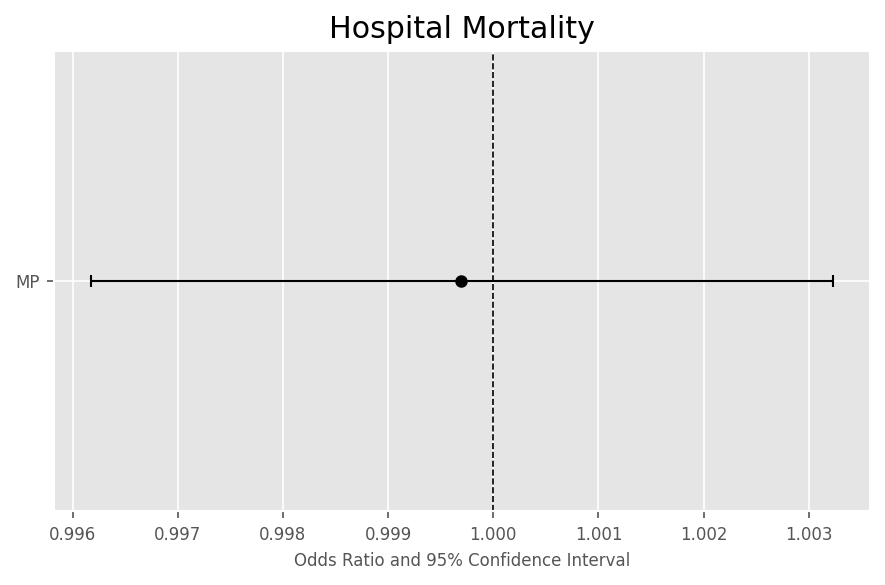

In [242]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('Hospital Mortality')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [243]:
#change outcome to ICU mortality
y2=Outcomes_final['mort_ICU']

#logistic model again
logit_model=sm.Logit(y2,X)
result2=logit_model.fit()
print(result2.summary2())
logreg = LogisticRegression()

Optimization terminated successfully.
         Current function value: 0.563414
         Iterations 10
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.047     
Dependent Variable:    mort_ICU          AIC:               3534.3204 
Date:                  2022-08-01 21:42  BIC:               3600.8113 
No. Observations:      3117              Log-Likelihood:    -1756.2   
Df Model:              10                LL-Null:           -1843.7   
Df Residuals:          3106              LLR p-value:       2.4077e-32
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        10.0000                                        
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
MP                     -0.0002   0.0017 -0.0948 0.9244 -0.0034  0.0031
Ag

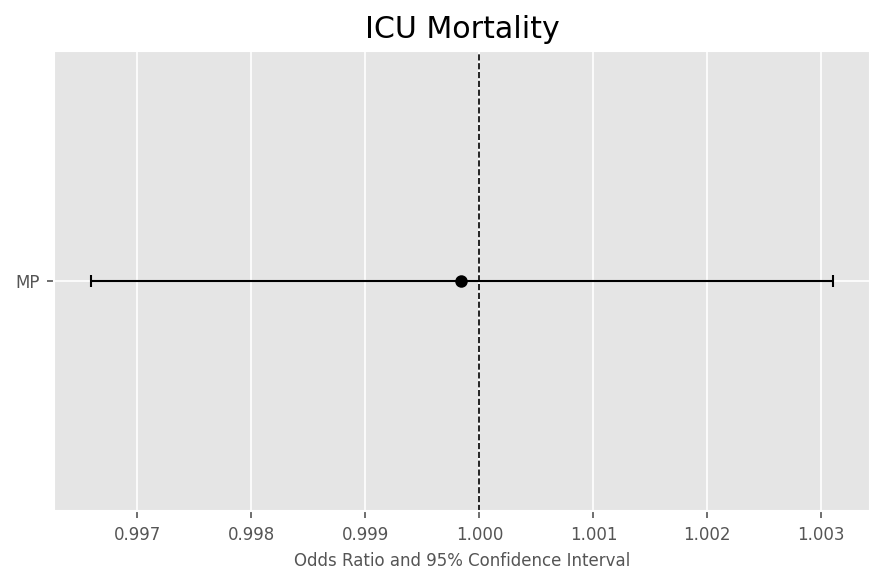

In [244]:
params = result2.params
conf = result2.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = result2.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in result2.pvalues]
MP=odds.head(1)

plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('ICU Mortality')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [245]:
y3=Outcomes_final['mort_30']
#logistic model again
logit_model=sm.Logit(y3,X)
result3=logit_model.fit()
print(result3.summary2())
logreg = LogisticRegression()

Optimization terminated successfully.
         Current function value: 0.579620
         Iterations 14
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.055     
Dependent Variable:    mort_30           AIC:               3635.3485 
Date:                  2022-08-01 21:42  BIC:               3701.8394 
No. Observations:      3117              Log-Likelihood:    -1806.7   
Df Model:              10                LL-Null:           -1912.4   
Df Residuals:          3106              LLR p-value:       6.7046e-40
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        14.0000                                        
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
MP                     -0.0006   0.0023 -0.2842 0.7762 -0.0051  0.0038
Ag

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


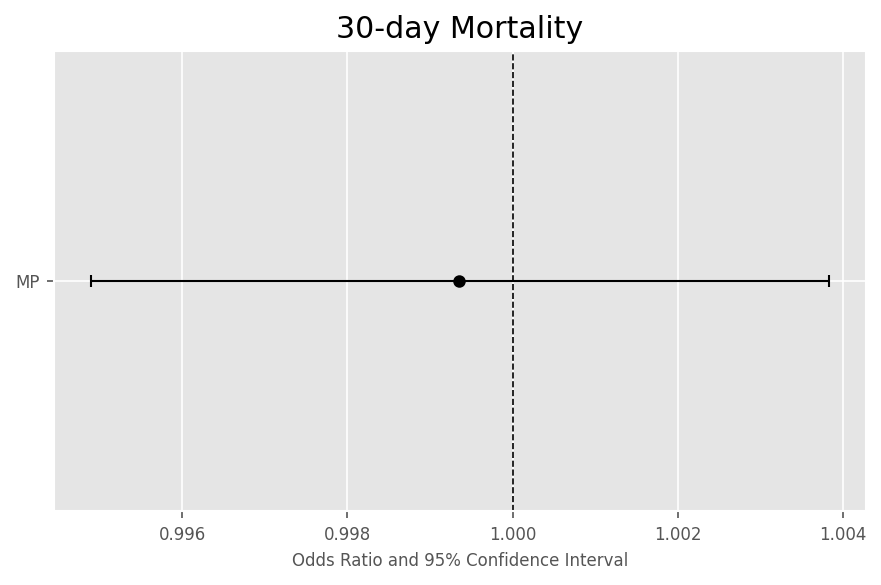

In [246]:
params = result3.params
conf = result3.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = result3.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in result3.pvalues]
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('30-day Mortality')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [247]:
y4=Outcomes_final['mort_year']
#logistic model again
logit_model=sm.Logit(y4,X)
result4=logit_model.fit()
print(result4.summary2())
logreg = LogisticRegression()

Optimization terminated successfully.
         Current function value: 0.593654
         Iterations 10
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.060     
Dependent Variable:    mort_year         AIC:               3722.8360 
Date:                  2022-08-01 21:42  BIC:               3789.3269 
No. Observations:      3117              Log-Likelihood:    -1850.4   
Df Model:              10                LL-Null:           -1969.1   
Df Residuals:          3106              LLR p-value:       2.3589e-45
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        10.0000                                        
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
MP                     -0.0006   0.0021 -0.2771 0.7817 -0.0048  0.0036
Ag

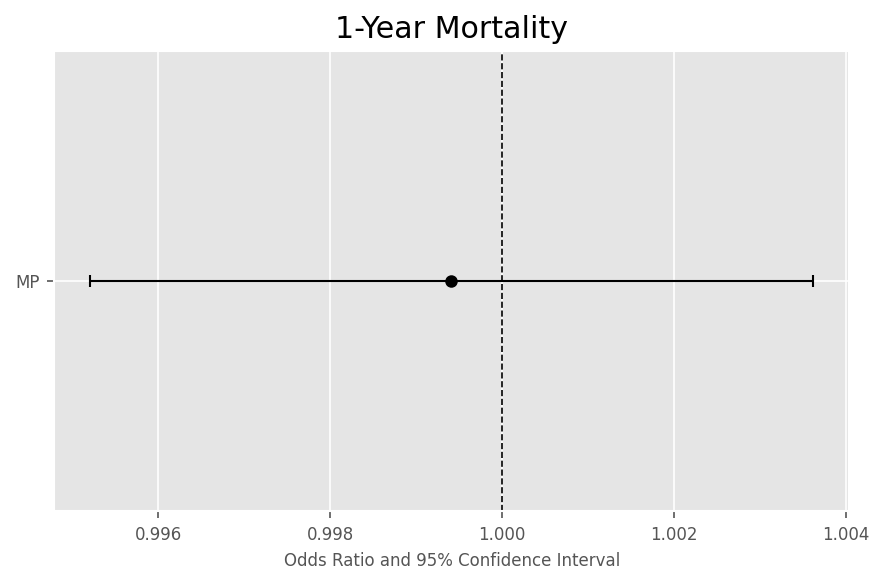

In [248]:
params = result4.params
conf = result4.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = result4.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in result4.pvalues]
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('1-Year Mortality')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [264]:
y5=Outcomes_final['Vent_free']
model = sm.OLS(y5, X)
result5 = model.fit()
print(result5.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.036     
Dependent Variable:     Vent_free        AIC:                         24959.6064
Date:                   2022-08-01 21:57 BIC:                         25026.0973
No. Observations:       3117             Log-Likelihood:              -12469.   
Df Model:               11               F-statistic:                 11.60     
Df Residuals:           3106             Prob (F-statistic):          1.64e-21  
R-squared (uncentered): 0.039            Scale:                       175.24    
----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
MP                        0.0032     0.0064    0.4981   0.6185   -0.0094    0.0158
Age                      -0.0355     0.0159  

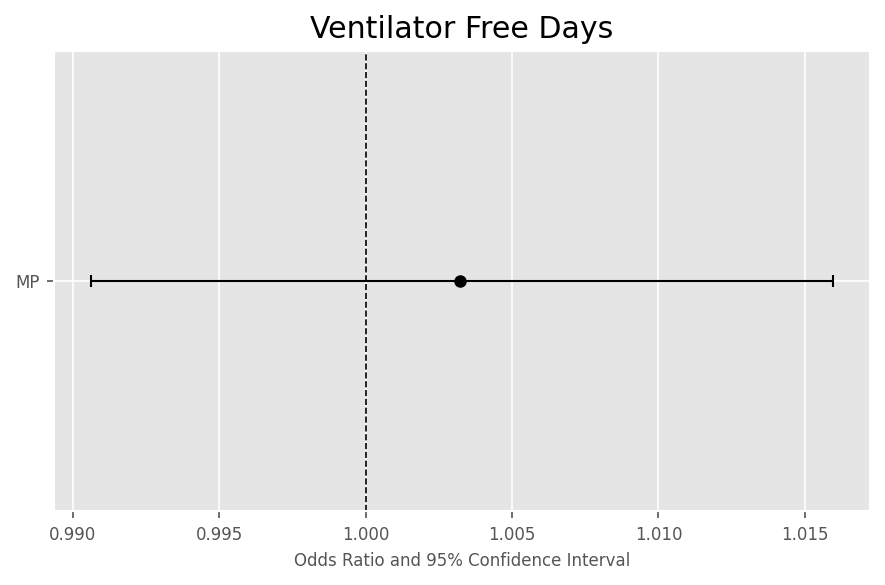

In [265]:
params = result5.params
conf = result5.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = result5.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in result5.pvalues]
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('Ventilator Free Days')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [262]:
y6=Outcomes_final['ICU_length']
model = sm.OLS(y6, X)
result6 = model.fit()
print(result6.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.603     
Dependent Variable:     ICU_length       AIC:                         23072.3762
Date:                   2022-08-01 21:56 BIC:                         23138.8671
No. Observations:       3117             Log-Likelihood:              -11525.   
Df Model:               11               F-statistic:                 431.4     
Df Residuals:           3106             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.604            Scale:                       95.651    
----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
MP                        0.0141     0.0048    2.9558   0.0031    0.0047    0.0234
Age                      -0.0026     0.0118  

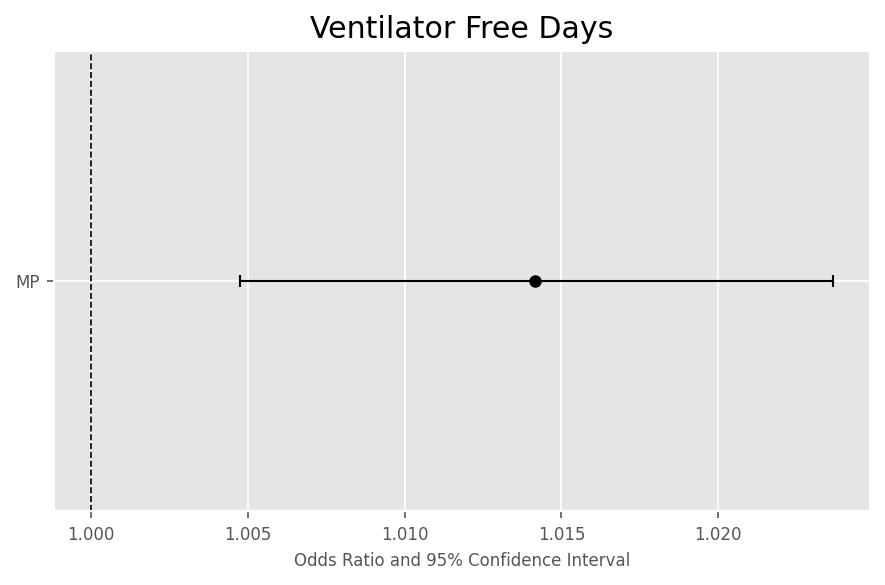

In [263]:
params = result6.params
conf = result6.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = result6.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in result6.pvalues]
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('Ventilator Free Days')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [266]:
y7=Outcomes_final['Hosp_length']
model = sm.OLS(y7, X)
result7 = model.fit()
print(result7.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.510     
Dependent Variable:     Hosp_length      AIC:                         27251.9654
Date:                   2022-08-01 21:58 BIC:                         27318.4563
No. Observations:       3117             Log-Likelihood:              -13615.   
Df Model:               11               F-statistic:                 295.7     
Df Residuals:           3106             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.512            Scale:                       365.63    
----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
MP                        0.0102     0.0093    1.0924   0.2747   -0.0081    0.0284
Age                      -0.0812     0.0230  

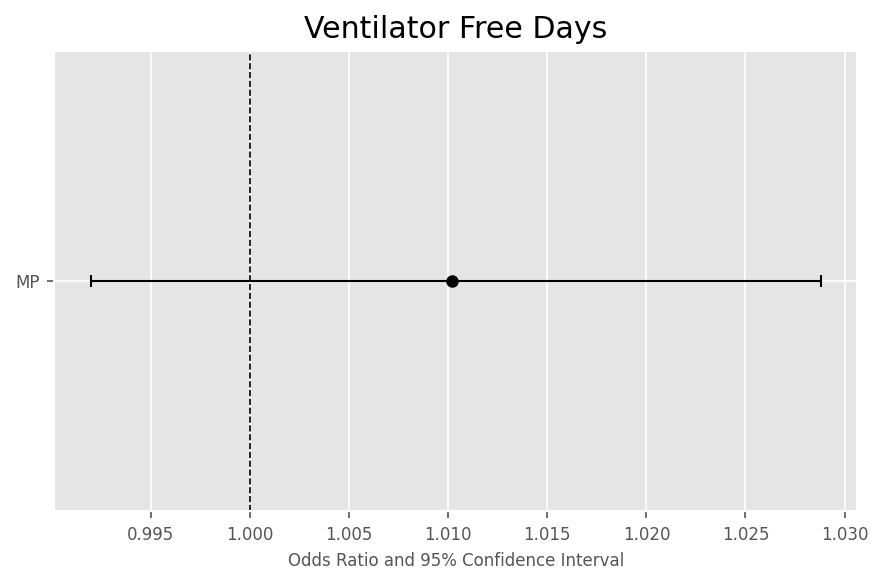

In [269]:
params = result7.params
conf = result7.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = result7.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in result7.pvalues]
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('Ventilator Free Days')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()